In [1]:
import time

start_time = time.time()

***The program is expected to run for a total duration of 17 minutes***


# Predicting the Price of Used Cars Using Machine Learning Algorithms
<font color = 'Blue'> 
Names: Shin Le, Jeongyeon Kim, Benjamin Horvath, Nico Reategui, Paul Giglio


Final Report: https://docs.google.com/document/d/1zhQrkWmJjjMU6wIfBC78MygGzp-XUrkaUOWALfyAL9Q/edit

Dataset: 
* https://www.kaggle.com/datasets/andreinovikov/used-cars-dataset

<a id="0"></a> <br>
<font color = 'Blue'> 
# Table of Contents

1. [About Dataset](#1)
2. [Importing Libraries](#2)
3. [Functions Implementation](#3)
4. [Loading Data](#4)
5. [Data Preprocessing](#5)
6. [Exploratory Data Analysis (EDA)](#6)
   1. [Filtering Data](#61)
   2. [Detecting Outliers](#62)
   3. [Labeling Encode](#63)
   4. [Correlation Matrix](#64)|
7. [Data Splitting](#7)
8. [Models Evaluations and Predictions](#8)
   1. [*Full Model* with *Linear Regression*](#81)
      1. [Using Sequential Feature Selection for the *Linear Regression*](#811)
   2. [*Decision Tree*](#82)
      1. [*A Pruned Tree*](#821)
   3. [Ensemble Method: *Random Forest Regression*](#83)
   4. [Ensemble Method: *Gradient Boosting Regression*](#84)
   5. [*Support Vector Machine* (SVM)](#85)
   6. [Comparing Models](#86)


<a id="1"></a>
<font color = 'blue'> 
## **1. About Dataset**

This dataset contains data about 762,091 used cars scraped from cars.com. The data was collected on Apr, 2023.

**Feature description**

* manufacturer - name of the car manufacturer
* model - name of the car model
* year - the year when the car was produced
* mileage - the number of miles the car has traveled since production
* engine - car engine
* transmission - type of the car's transmission
* drivetrain - type of the car's drivetrain
* fuel_type - type of fuel that the car consumes
* mpg - the number of miles a car can travel using one gallon of fuel (miles per gallon)
* exterior_color - car exterior color
* interior_color - car interior color
* accidents_or_damage - whether the car was involved in accidents
* one_owner - whether the car was owned by one person
* personal_use_only - whether the car was used only for personal purposes
* seller_name - name of the seller
* seller_rating - seller's rating
* driver_rating - car rating given by drivers
* driver_reviews_num - the number of car reviews left by drivers
* price_drop - price reduction from the initial price
* price - car price

<a id="2"></a>
<font color = 'blue'> 
## **2. Importing Libraries**

In [2]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

 # Plot
import matplotlib.pyplot as plt 
from matplotlib.pyplot import subplots


#feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, Lasso

#Metrics:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,RocCurveDisplay

#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
import sklearn.model_selection as skm

#tree
from sklearn.tree import DecisionTreeRegressor,plot_tree ,export_text
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import sklearn.tree as tree 
from ISLP.bart import BART

#SVM
from sklearn.svm import SVR

#loading data
import requests
import zipfile
import io
import os
from os.path import expanduser

#preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder 

#searborn
import seaborn as sns   #using heatmap

#splitting dataset into train and test data
from sklearn.model_selection import train_test_split,cross_val_predict


<a id="3"></a>
<font color = 'blue'> 
## **3. Functions Implementation**


* #### CORRELATION MATRIX

In [3]:
def heat_map(data, var):
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Create a figure with a specific size
    plt.figure(figsize=(len(var) * 2, len(var) * 1.5))
    
    # Create a mask for the upper triangle to focus on the center
    mask = np.triu(np.ones_like(correlation_matrix), k=0)

    # Customize the color scale (cmap) to emphasize the center
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Increase the font size for annotations
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, mask=mask,  vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 18})
    plt.xticks(rotation=45, ha='right',fontsize=20)
    plt.yticks(rotation=0, ha='right',fontsize=20)
    plt.title('Correlation Heatmap',fontsize=20)

    plt.show()

<a id="4"></a>
<font color = 'blue'> 
## **4. Loading Data**

In [4]:

# URL of the ZIP file
url = "https://github.com/syl21b/Car-Price-Prediction/raw/main/cars.csv.zip"

# Directory to save extracted files in your home directory
output_directory = os.path.join(expanduser("~"), "car_data")

# Ensure the output directory exists or create it if not
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Send a GET request to the URL
response = requests.get(url)

if response.status_code == 200:
    # Create a BytesIO object to work with the content
    zip_data = io.BytesIO(response.content)

    # Create a ZipFile object to extract the contents
    with zipfile.ZipFile(zip_data, 'r') as zip_ref:
        # Extract all files from the ZIP archive to the output directory
        zip_ref.extractall(output_directory)

    print("ZIP file has been successfully downloaded and extracted to the specified directory.")
else:
    print(f"Failed to download ZIP file. Status code: {response.status_code}")

# Load the CSV file into a DataFrame
csv_file_path = os.path.join(output_directory, "cars.csv")
df = pd.read_csv(csv_file_path)

# Now you can work with the 'df' DataFrame


Failed to download ZIP file. Status code: 404


<a id="5"></a>
<font color = 'blue'> 
## **5. Data Preprocessing**

In [5]:
# Sample data
df = pd.DataFrame(df)

# Use str.extract to create new columns
df[['Engine Displacement (L)', 'Engine Type', 'Engine Features']] = df['engine'].str.extract(r'(\d+\.\d+)L\s([A-Z0-9]+)\s(.+)$')

# Drop the original 'engine' column if you no longer need it
df = df.drop(columns=['engine'])

# Print the DataFrame
df

manufacturer                         model  year   mileage  \
0             Mazda  CX-90 3.3 Turbo Premium Plus  2024       1.0   
1             Mazda          CX-90 S Premium Plus  2024       1.0   
2             Acura                Integra A-Spec  2023       6.0   
3             Acura     Integra A-Spec Technology  2023    9705.0   
4             Acura     Integra A-Spec Technology  2023       6.0   
...             ...                           ...   ...       ...   
758030       Toyota                   Supra Turbo  1995   15800.0   
758031       Toyota                   Supra Turbo  1995   44614.0   
758032   Volkswagen                       Eurovan  1995   91849.0   
758033   Volkswagen            Eurovan Campmobile  1995  190336.0   
758034        Volvo                           850  1995   87016.0   

             transmission         drivetrain fuel_type    mpg  \
0       8-Speed Automatic    All-wheel Drive  Gasoline    NaN   
1       8-Speed Automatic    All-wheel Drive  Gasoline    NaN   
2           Automatic CVT  Front-wheel Drive  Gasoline  29-36   
3           Automatic CVT  Front-wheel Drive  Gasoline  29-36   
4           Automatic CVT  Front-wheel Drive  Gasoline  29-36   
...                   ...                ...       ...    ...   
758030     6-Speed Manual                NaN  Gasoline  17-23   
758031     6-Speed Manual   Rear-wheel Drive  Gasoline    NaN   
758032             Manual  Front-wheel Drive  Gasoline    NaN   
758033     5-Speed Manual  Front-wheel Drive  Gasoline    NaN   
758034  4-Speed Automatic  Front-wheel Drive  Gasoline  19-26   

              exterior_color interior_color  ...  personal_use_only  \
0                        51K          White  ...                1.0   
1       Artisan Red Metallic          White  ...                1.0   
2                        Red          Ebony  ...                0.0   
3       Platinum White Pearl          Ebony  ...                1.0   
4                Performance         Orchid  ...                1.0   
...                      ...            ...  ...                ...   
758030                 Black            Tan  ...                1.0   
758031                Silver          Black  ...                1.0   
758032                 White           Gray  ...                1.0   
758033                 White           Gray  ...                1.0   
758034                 Green            NaN  ...                1.0   

                          seller_name  seller_rating driver_rating  \
0                           Cox Mazda            3.2           NaN   
1                           Cox Mazda            3.2           NaN   
2             Glenview Luxury Imports            4.9           4.6   
3                       Lindsay Acura            3.6           4.6   
4                     Plaza Auto Mall            4.0           4.6   
...                               ...            ...           ...   
758030              Motorcar Classics            3.7           4.9   
758031              Gold Coast Motors            NaN           4.9   
758032  Pacific Auto Center - Fontana            3.1           4.8   
758033                         Lot 99            1.4           4.8   
758034                Elite Auto Corp            3.1           4.4   

        driver_reviews_num  price_drop   price  Engine Displacement (L)  \
0                        0         NaN   54920                      3.3   
1                        0         NaN   61920                      NaN   
2                        5         NaN   37434                      1.5   
3                        5       484.0   34516                      1.5   
4                        5       674.0   33221                      1.5   
...                    ...         ...     ...                      ...   
758030                   7     10000.0   89900                      3.0   
758031                   7      6000.0  109900                      3.0   
758032                   3  

##### Before handling data
* Show the frequency of unique values for each column. This will initially show us the classes which have the highest frequency. We consider these as outliers.

In [6]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

Ford             78680
Toyota           59393
Chevrolet        54828
Nissan           48482
Jeep             41543
Mercedes-Benz    40582
Honda            37601
BMW              37509
Kia              35063
GMC              29507
Dodge            25102
Subaru           24762
Volkswagen       24485
Hyundai          22203
Lexus            21292
RAM              19364
Audi             17863
Cadillac         17614
Mazda            15431
Buick            14509
Chrysler         12609
INFINITI         12287
Land Rover       12139
Porsche          11214
Lincoln          10518
Volvo            10022
Acura             8468
Tesla             5883
Mitsubishi        5737
Jaguar            3345
Name: manufacturer, dtype: int64, 

Fusion SE                                3172
Sportage LX                              2873
Corolla LE                               2835
GLC 300 Base 4MATIC                      2718
Sentra SV                                2652
                                         ...

<a id="6"></a>
<font color = 'blue'> 
## **6. Exploratory Data Analysis (EDA)**

<a id="61"></a>
<font color = 'blue'> 
### ***1. Filtering data***


* #### Handle Missing value
   * Price Column - Target

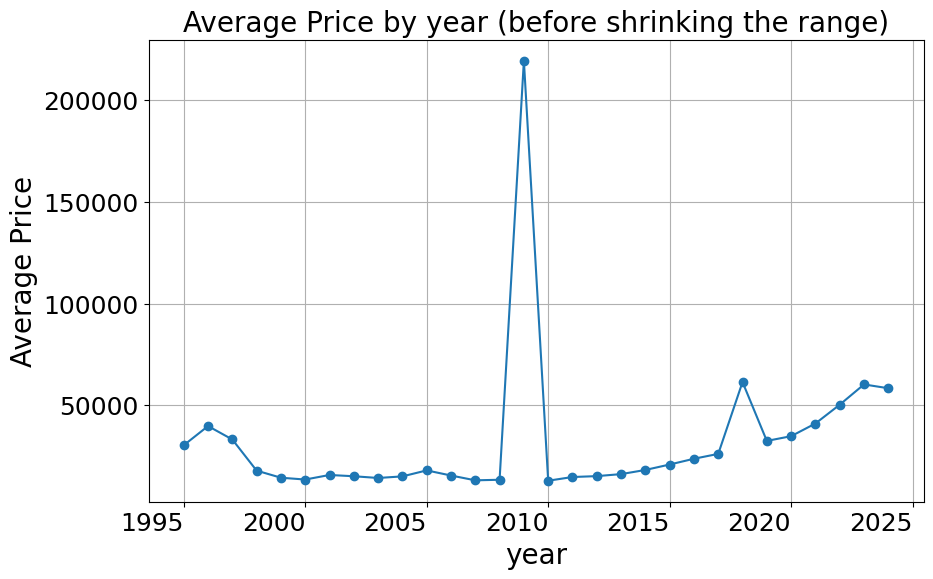

In [7]:
# before shrinkage
mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Average Price by year (before shrinking the range)', fontsize=20)
plt.xlabel('year', fontsize=20)
plt.ylabel('Average Price', fontsize=20)
# Add font size for ticks
plt.xticks(ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>Problem:</b>
The original dataset has the abnormal Average Price in year 2009. So, we shrink the Price in the range (0,200000). This could a way to handle outliers. 
</div>



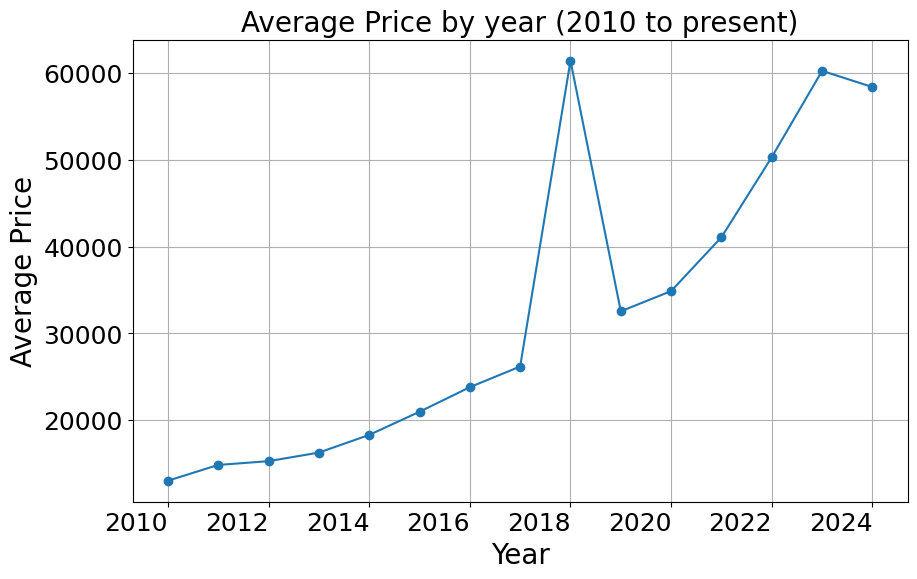

In [8]:
# Filter the DataFrame to include data from 2010 to the present
df_filtered = df[df['year'] >= 2010]

# Group by year and calculate the mean price
mean_prices_by_year = df_filtered.groupby('year')['price'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Average Price by year (2010 to present)', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Average Price', fontsize=20)
# Add font size for ticks
plt.xticks(ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

In [9]:
df=df[df['price'].between(0,200000)]

In [10]:

# Group by the 'year' column and calculate the Average Price for each year
yearly_mean_prices = df.groupby('year')['price'].mean()

# Fill NaN values in the 'price' column with the Average Price of their respective year
df['price'].fillna(df['year'].map(yearly_mean_prices), inplace=True)


/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_27368/3540215951.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'].fillna(df['year'].map(yearly_mean_prices), inplace=True)


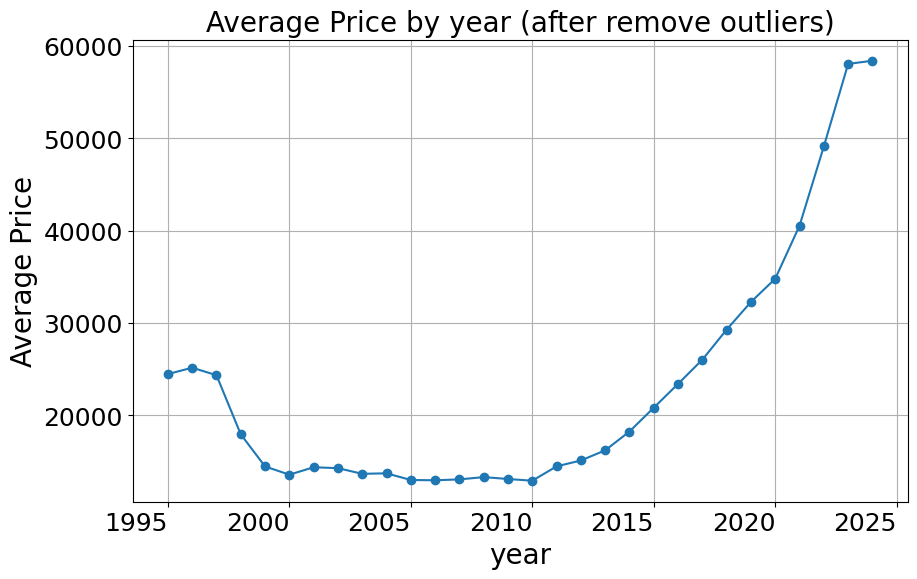

In [11]:
mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Average Price by year (after remove outliers)', fontsize=20)
plt.xlabel('year', fontsize=20)
plt.ylabel('Average Price', fontsize=20)
# Add font size for ticks
plt.xticks(ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

#### Mapping from long form to abbreviation


* `Drivetrain`

In [12]:
df = pd.DataFrame(df)

# Create a mapping from long form to abbreviation
drivetrain_mapping = {
    'All-wheel Drive': 'AWD',
    'Front-wheel Drive': 'FWD',
    'Four-wheel Drive': '4WD',
    'Rear-wheel Drive': 'RWD'
}

# Use the replace method to update the drivetrain column
df['drivetrain'] = df['drivetrain'].replace(drivetrain_mapping)

* fuel_type

In [13]:
df = pd.DataFrame(df)
# Create a dictionary for mapping
drivetrain_mapping = {
    'Gasoline Fuel': 'Gasoline',
    'Gas': 'Gasoline',
    'Plug-In Hybrid': 'Hybrid',
    'Hybrid Fuel': 'Hybrid',
    'Gas/Electric Hybrid': 'Hybrid',
    'Gasoline/Mild Electric Hybrid': 'Hybrid',
    'Diesel Fuel': 'Diesel',
    'Rear-wheel Drive': 'Electric',
    'E85 Flex Fuel': 'Flex Fuel',
    'Flex Fuel Capability': 'Flex Fuel'
}

# Use the replace method to update the drivetrain column
df['fuel_type'] = df['fuel_type'].replace(drivetrain_mapping)

* #### Splitting `MPG` column into two separate columns

In [14]:
df['mpg'].fillna('0-0', inplace=True)

In [15]:
# Split the "MPG Range" into two columns
df[['City MPG', 'Highway MPG']] = df['mpg'].str.split('-', expand=True)

In [16]:
# Custom function to convert elements to int or replace with zero
def convert_to_int_or_zero(value):
    if isinstance(value, str):
        # Remove non-numeric characters and try to convert to int
        numeric_value = ''.join(filter(str.isdigit, value))
        if numeric_value:
            return int(numeric_value)
    return 0

# Apply the custom function to 'City MPG' and 'Highway MPG' columns
df['City MPG'] = df['City MPG'].apply(convert_to_int_or_zero)
df['Highway MPG'] = df['Highway MPG'].apply(convert_to_int_or_zero)

In [17]:
# Replace "N/A" values with 0
df['City MPG'] .replace(0, np.nan, inplace=True)
df['Highway MPG'].replace(0, np.nan, inplace=True)

In [18]:
df= df.drop('mpg', axis=1)

In [19]:
df.isnull().sum()

manufacturer                    0
model                           0
year                            0
mileage                       478
transmission                 9558
drivetrain                  19410
fuel_type                   21103
exterior_color               8680
interior_color              56253
accidents_or_damage         24026
one_owner                   29230
personal_use_only           24130
seller_name                  8495
seller_rating              210877
driver_rating               29309
driver_reviews_num              0
price_drop                 348758
price                           0
Engine Displacement (L)    116191
Engine Type                116191
Engine Features            116191
City MPG                   145894
Highway MPG                153944
dtype: int64

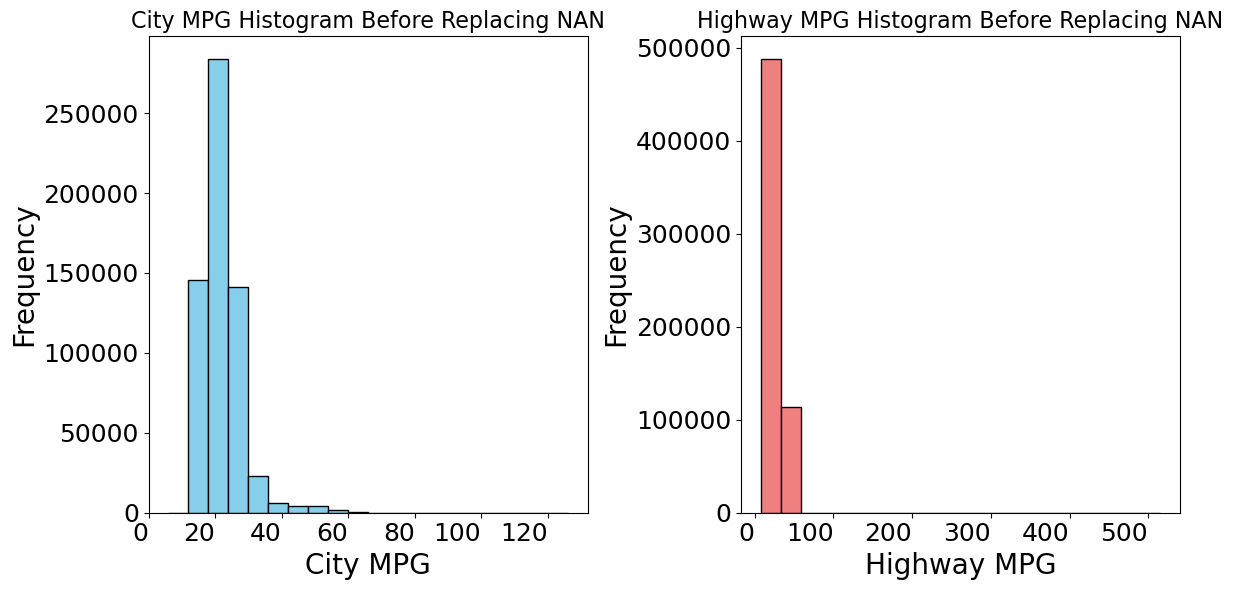

In [20]:
def create_mpg_histogram(df, str):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df['City MPG'], bins=20, color='skyblue', edgecolor='black')
    plt.title('City MPG Histogram '+str+' Replacing NAN', fontsize=16)
    plt.xlabel('City MPG', fontsize=20)
    # Add font size for ticks
    plt.xticks(ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Frequency', fontsize=20)
        

    plt.subplot(1, 2, 2)
    plt.hist(df['Highway MPG'], bins=20, color='lightcoral', edgecolor='black')
    plt.title('Highway MPG Histogram '+str+' Replacing NAN', fontsize=16)
    plt.xlabel('Highway MPG', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    # Add font size for ticks
    plt.xticks(ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

    # Show the histograms
    plt.show()
    
create_mpg_histogram(df, 'Before')

* #### **Replace `NAN` in '`City MPG`' and '`Highway MPG`' by the `Mean` of each column**

In [21]:
df['City MPG'] .replace(np.nan,df['City MPG'].mean(), inplace=True)
df['Highway MPG'].replace(np.nan,df['Highway MPG'].mean(), inplace=True)

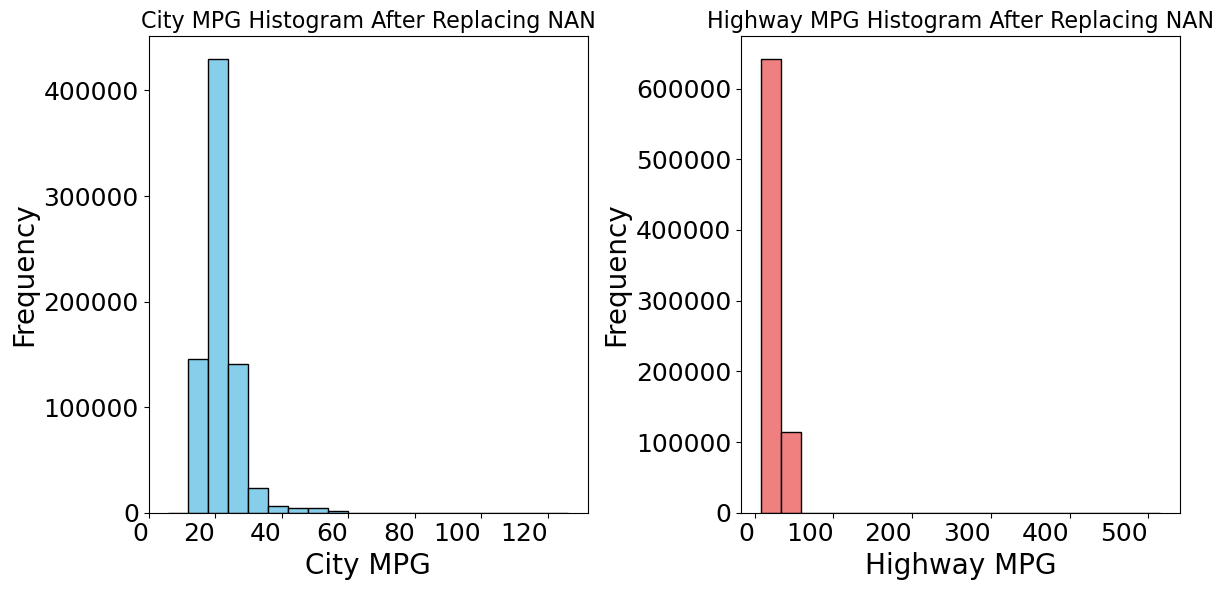

In [22]:
create_mpg_histogram(df, 'After')

In [23]:
df= df.drop('price_drop', axis=1)       #Drop this column since it does not provide useful information and has a lot of null values.

* #### **Handling `NAN` in `seller_rating`**

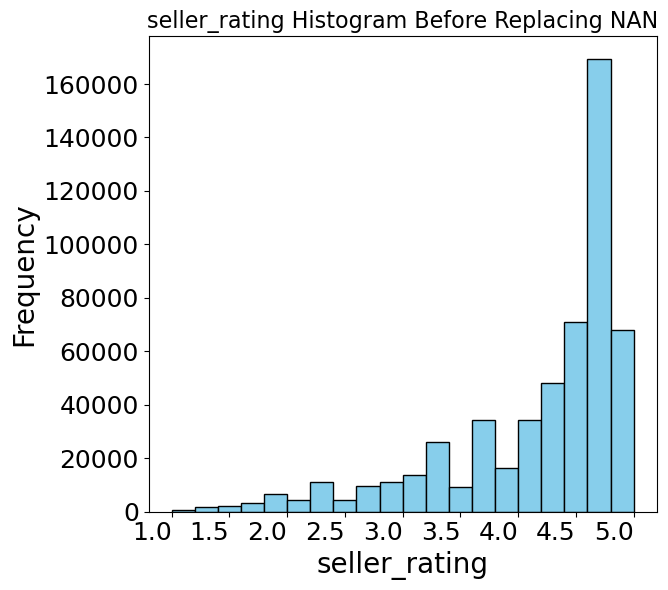

In [24]:

def create_seller_rating_histograms(df, str):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df['seller_rating'], bins=20, color='skyblue', edgecolor='black')
    plt.title('seller_rating Histogram '+str+' Replacing NAN', fontsize=16)
    plt.xlabel('seller_rating', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    # Add font size for ticks
    plt.xticks(ha='right', fontsize=18)
    plt.yticks(fontsize=18)
        
    plt.tight_layout()

    # Show the histograms
    plt.show()
    
create_seller_rating_histograms(df, 'Before')

In [25]:
df['seller_rating'].replace(np.nan,df['seller_rating'].mean(), inplace=True) #replace missing value by the mean

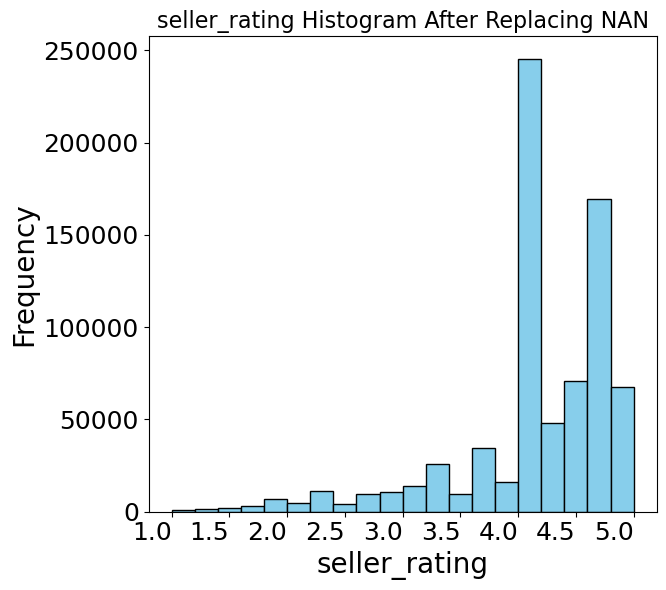

In [26]:
create_seller_rating_histograms(df, 'After')

In [27]:
df.dropna()

manufacturer                      model  year   mileage  \
2             Acura             Integra A-Spec  2023       6.0   
3             Acura  Integra A-Spec Technology  2023    9705.0   
6             Acura  Integra A-Spec Technology  2023   10805.0   
7             Acura             Integra A-Spec  2023    6612.0   
8             Acura  Integra A-Spec Technology  2023    3305.0   
...             ...                        ...   ...       ...   
758016       Toyota                   Camry LE  1995  126451.0   
758017       Toyota             4Runner SR5 V6  1995  200331.0   
758020       Toyota                 Corolla DX  1995  168722.0   
758028       Toyota               Land Cruiser  1995  237603.0   
758033   Volkswagen         Eurovan Campmobile  1995  190336.0   

             transmission drivetrain fuel_type         exterior_color  \
2           Automatic CVT        FWD  Gasoline                    Red   
3           Automatic CVT        FWD  Gasoline   Platinum White Pearl   
6          6-Speed Manual        FWD  Gasoline                   Gray   
7           Automatic CVT        FWD  Gasoline        Apex Blue Pearl   
8           Automatic CVT        FWD  Gasoline  Performance Red Pearl   
...                   ...        ...       ...                    ...   
758016  4-Speed Automatic        RWD  Gasoline                    Tan   
758017     5-Speed Manual        4WD  Gasoline     Dark Gray Metallic   
758020     5-Speed Manual        FWD  Gasoline   Wintergreen Metallic   
758028  4-Speed Automatic        4WD  Gasoline                  Green   
758033     5-Speed Manual        FWD  Gasoline                  White   

       interior_color  accidents_or_damage  ...                   seller_name  \
2               Ebony                  0.0  ...       Glenview Luxury Imports   
3               Ebony                  0.0  ...                 Lindsay Acura   
6               Ebony                  0.0  ...                Honda of Keene   
7               Ebony                  0.0  ...               Audi Fort Myers   
8              Orchid                  0.0  ...              Acura of Concord   
...               ...                  ...  ...                           ...   
758016            Tan                  0.0  ...                  Uzdcarz Inc.   
758017           Gray                  0.0  ...               Columbia Motors   
758020           Gray                  1.0  ...  Performance Toyota Bountiful   
758028            Tan                  1.0  ...  Dynamic Motorsports Of Texas   
758033           Gray                  0.0  ...                        Lot 99   

        seller_rating driver_rating  driver_reviews_num  price  \
2            4.900000           4.6                   5  37434   
3            3.600000           4.6                   5  34516   
6            4.500000           4.6                   5  37500   
7            4.600000           4.6                   5  32995   
8            4.159732           4.6                   5  34019   
...               ...           ...                 ...    ...   
758016       4.159732           4.5                  32   3488   
758017       2.900000           4.2                   8   9991   
758020       4.200000           4.3                  18   5000   
758028       4.159732           4.6                   6  16995   
758033       1.400000           4.8                   3  25995   

        Engine Displacement (L)  Engine Type     Engine Features   City MPG  \
2                           1.5           I4  16V GDI DOHC Turbo  29.000000   
3                           1.5           I4  16V GDI DOHC Turbo  29.000000   
6                           1.5           I4  16V GDI DOHC Turbo  26.000000   
7                           1.5           I4  16V GDI DOHC Turbo  29.000000   
8                           1.5           I4  16V GDI DOHC Turbo  29.000000   
...                         ...          ...                 ...        ...   
758016            

In [28]:
df.isnull().sum() # Checking null values on each column

manufacturer                    0
model                           0
year                            0
mileage                       478
transmission                 9558
drivetrain                  19410
fuel_type                   21103
exterior_color               8680
interior_color              56253
accidents_or_damage         24026
one_owner                   29230
personal_use_only           24130
seller_name                  8495
seller_rating                   0
driver_rating               29309
driver_reviews_num              0
price                           0
Engine Displacement (L)    116191
Engine Type                116191
Engine Features            116191
City MPG                        0
Highway MPG                     0
dtype: int64

In [29]:
# Use value_counts to count the frequency of each Engine Type
engine_type_counts = df['Engine Features'].value_counts()

# Get the top 20 values with the highest frequency
top_20_engine_types = engine_type_counts.head(40)

# Print the top 20 values and their frequencies
print(top_20_engine_types)

16V GDI DOHC Turbo                  121200
24V MPFI DOHC                        71454
16V MPFI DOHC                        58584
16V GDI DOHC                         56198
24V GDI DOHC                         43984
16V GDI OHV                          21721
24V GDI DOHC Twin Turbo              18418
16V MPFI OHV                         18140
16V MPFI SOHC                        17515
24V GDI DOHC Turbo                   15633
24V PDI DOHC                         15596
16V MPFI DOHC Hybrid                 12292
32V DDI OHV Turbo Diesel             11828
16V PDI DOHC                         11134
32V MPFI DOHC                         9823
32V GDI DOHC Twin Turbo               9516
24V GDI SOHC                          9065
16V MPFI DOHC Turbo                   8086
32V GDI DOHC                          6591
16V PDI DOHC Turbo                    6468
24V PDI DOHC Twin Turbo               6163
16V PDI DOHC Hybrid                   6024
24V MPFI SOHC                         5982
Cylinder En

In [30]:
df.isnull().sum() #count the null values on each column

manufacturer                    0
model                           0
year                            0
mileage                       478
transmission                 9558
drivetrain                  19410
fuel_type                   21103
exterior_color               8680
interior_color              56253
accidents_or_damage         24026
one_owner                   29230
personal_use_only           24130
seller_name                  8495
seller_rating                   0
driver_rating               29309
driver_reviews_num              0
price                           0
Engine Displacement (L)    116191
Engine Type                116191
Engine Features            116191
City MPG                        0
Highway MPG                     0
dtype: int64

We still have a lot of null value

In [31]:
df.shape

(756724, 22)

* #### ...after filtering data

In [32]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

Ford             78646
Toyota           59390
Chevrolet        54813
Nissan           48472
Jeep             41542
Mercedes-Benz    40094
Honda            37601
BMW              37491
Kia              35063
GMC              29501
Dodge            25091
Subaru           24761
Volkswagen       24485
Hyundai          22202
Lexus            21292
RAM              19362
Audi             17847
Cadillac         17585
Mazda            15431
Buick            14509
Chrysler         12609
INFINITI         12287
Land Rover       12060
Porsche          10629
Lincoln          10517
Volvo            10022
Acura             8458
Tesla             5883
Mitsubishi        5737
Jaguar            3344
Name: manufacturer, dtype: int64, 

Fusion SE                                    3172
Sportage LX                                  2873
Corolla LE                                   2835
GLC 300 Base 4MATIC                          2718
Sentra SV                                    2652
                        

In [33]:
df.info() #shows a summary of our dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756724 entries, 0 to 758034
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   manufacturer             756724 non-null  object 
 1   model                    756724 non-null  object 
 2   year                     756724 non-null  int64  
 3   mileage                  756246 non-null  float64
 4   transmission             747166 non-null  object 
 5   drivetrain               737314 non-null  object 
 6   fuel_type                735621 non-null  object 
 7   exterior_color           748044 non-null  object 
 8   interior_color           700471 non-null  object 
 9   accidents_or_damage      732698 non-null  float64
 10  one_owner                727494 non-null  float64
 11  personal_use_only        732594 non-null  float64
 12  seller_name              748229 non-null  object 
 13  seller_rating            756724 non-null  float64
 14  driv

* Check and drop **Null** values

In [34]:
df.isnull().sum()

manufacturer                    0
model                           0
year                            0
mileage                       478
transmission                 9558
drivetrain                  19410
fuel_type                   21103
exterior_color               8680
interior_color              56253
accidents_or_damage         24026
one_owner                   29230
personal_use_only           24130
seller_name                  8495
seller_rating                   0
driver_rating               29309
driver_reviews_num              0
price                           0
Engine Displacement (L)    116191
Engine Type                116191
Engine Features            116191
City MPG                        0
Highway MPG                     0
dtype: int64

There is null value in **fuel_consumption_g_km** column. So, we need to drop these before using it

In [35]:
df=df.dropna().reset_index(drop=True)

* Check and drop duplicates:

In [36]:
df=df.drop_duplicates()

The data set after cleaning up

In [37]:
df.shape

(537830, 22)

* Counting the data for each feature:

We can observe the presence of outliers, and the data spans a wide range.

<a id="62"></a>
<font color = 'blue'> 
### **2. Detecting outliers**
* #### **For numerical columns**

Getting numerical columns

In [38]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#numerical_cols.remove()
num_columns=df[numerical_cols]

In [39]:
numerical_cols

['year',
 'mileage',
 'accidents_or_damage',
 'one_owner',
 'personal_use_only',
 'seller_rating',
 'driver_rating',
 'driver_reviews_num',
 'price',
 'City MPG',
 'Highway MPG']

* Average Price by year with outliers

<div class="alert alert-block alert-warning">
<b>Note:</b>  This method is just applied for <b>numerical features</b>. <br>
There is no specific way to detect outlier for <b>categorical columns</b>. We can plot the Frequency vs Price for each categorical columns, and then decide the outliers depend on the frequency.
</div>


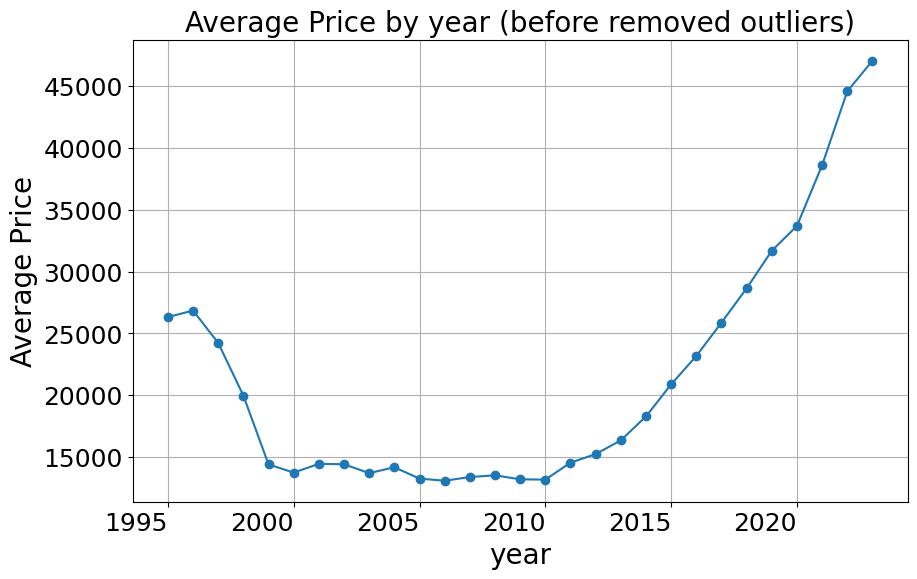

In [40]:
mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Average Price by year (before removed outliers)', fontsize=20)
plt.xlabel('year', fontsize=20)
plt.ylabel('Average Price', fontsize=20)
# Add font size for ticks
plt.xticks(ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

We can see that in 2009, the price was so abnormal 

In [41]:
Q1 = num_columns[numerical_cols].quantile(0.25)
Q3 = num_columns[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers and create a boolean mask
outliers_mask = (num_columns[numerical_cols] < lower_bound) | (num_columns[numerical_cols] > upper_bound)

# Drop the rows containing outliers
num_columns = num_columns[~outliers_mask]

In [42]:
numerical_cols

['year',
 'mileage',
 'accidents_or_damage',
 'one_owner',
 'personal_use_only',
 'seller_rating',
 'driver_rating',
 'driver_reviews_num',
 'price',
 'City MPG',
 'Highway MPG']

In [43]:
num_columns.shape

(537830, 11)

This is new numerical columns after removed the outliers

In [44]:
new_num_columns= num_columns.dropna() #drop the rows which are contain NAN 
new_num_columns.shape

(300539, 11)

* Plot Average Price vs Years ((after removed outliers))


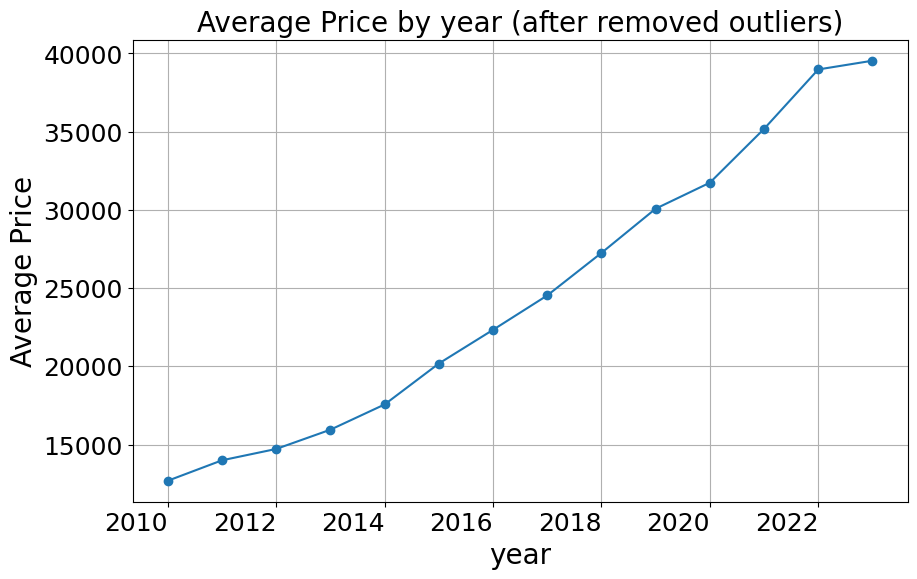

In [45]:
mean_prices_by_year = num_columns.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Average Price by year (after removed outliers)', fontsize=20)
plt.xlabel('year', fontsize=20)
plt.ylabel('Average Price', fontsize=20)
# Add font size for ticks
plt.xticks(ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

<a id=""></a>
<font color = 'blue'>
* ### **For categorical columns:**


We need to plot them vs Price to see the pattern

* Drop 'model', 'seller_name'

In [46]:
df=df.drop(['model', 'seller_name'], axis=1)

In [47]:
cat_columns= df.select_dtypes(include=['object']).columns.tolist()
#these are the columns that we need to plot to detect the outliers

In [48]:
df = df.loc[~df['transmission'].isin(['Unknown', 'Semi-automatic'])]

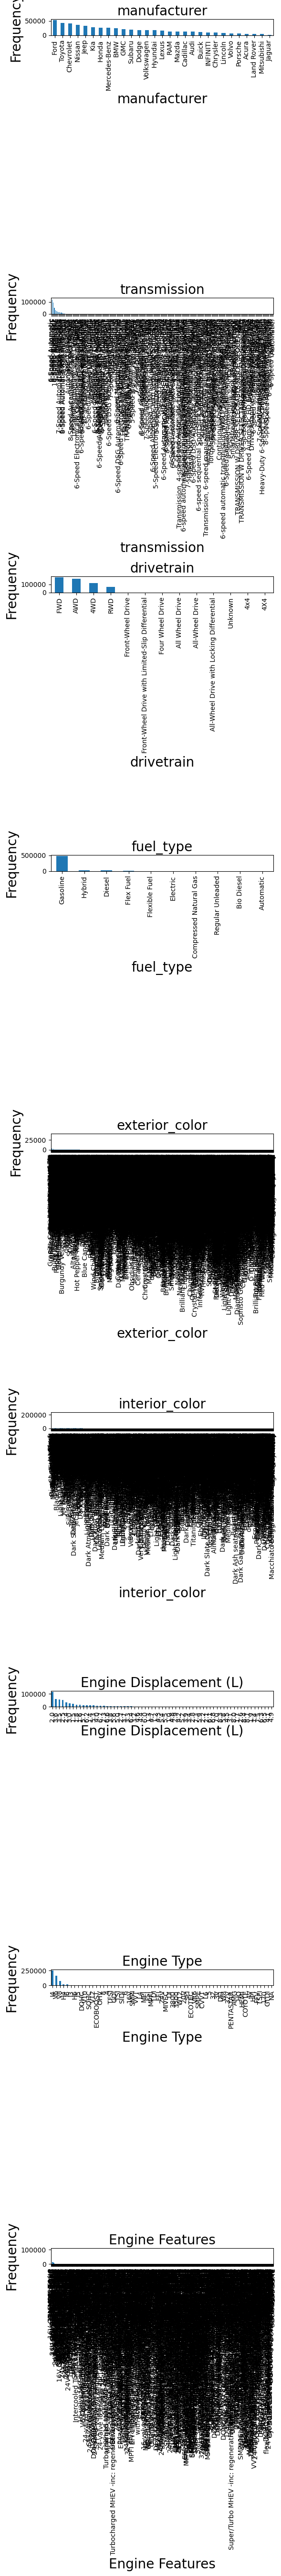

In [49]:
def plot_categorical_feature(cat_columns,df):
    fig = plt.figure(figsize=(6, 6 * len(cat_columns)))

    for j, cat_feature in enumerate(cat_columns):
        ax = fig.add_subplot(len(cat_columns), 1, j+1)
        df[cat_feature].value_counts().plot(ax=ax, kind='bar')
        ax.set_xlabel(cat_feature, fontsize=20)
        ax.set_ylabel('Frequency', fontsize=20)
        ax.set_title(cat_feature, fontsize=20)
      
        
        

    plt.tight_layout()
    plt.show()
# plot categorical features to detect and remove outliers
plot_categorical_feature(cat_columns,df)

In [50]:
df.shape

(537830, 20)

* `Drivetrain`

In [51]:
df = df[df['drivetrain'].isin(['FWD', 'AWD', '4WD', 'RWD'])]

* `Fuel_type`

In [52]:
df = df[~df['fuel_type'].isin(['Compressed Natural Gas', 'Bio Diesel', 'Automatic'   ])]

* We just keep top 20 classes which are the most common in `exterior_color`, `interior_color`

In [53]:
value_counts = df['exterior_color'].value_counts()
# Get the top 20 most frequent classes
top_20_classes = value_counts.index[:20]
# Filter the DataFrame to keep rows in the top 20 classes
df = df[df['exterior_color'].isin(top_20_classes)]

In [54]:
value_counts = df['interior_color'].value_counts()
# Get the top 20 most frequent classes
top_20_classes = value_counts.index[:20]
# Filter the DataFrame to keep rows in the top 20 classes
df = df[df['interior_color'].isin(top_20_classes)]

* `Engine Displacement (L)`

In [55]:
value_counts = df['Engine Displacement (L)'].value_counts()
# Get the top 30 most frequent classes
top_30_classes = value_counts.index[:30]
# Filter the DataFrame to keep rows in the top 30 classes
df = df[df['Engine Displacement (L)'].isin(top_30_classes)]

* `Engine Type` (top 10)

In [56]:
value_counts = df['Engine Type'].value_counts()
# Get the top 10 most frequent classes
top_10_classes = value_counts.index[:10]
# Filter the DataFrame to keep rows in the top 10 classes
df = df[df['Engine Type'].isin(top_10_classes)]

* `Engine Features`

In [57]:
value_counts = df['Engine Features'].value_counts()
# Get the top 20 most frequent classes
top_20_classes = value_counts.index[:20]
# Filter the DataFrame to keep rows in the top 20 classes
df = df[df['Engine Features'].isin(top_20_classes)]


* We just keep top 20 classes which are the most popular in `Transmission`

In [58]:
# Get the value counts for the 'transmission' column
value_counts = df['transmission'].value_counts()

# Get the top 20 most frequent classes
top_20_classes = value_counts.index[:20]

# Filter the DataFrame to keep rows with 'transmission' in the top 20 classes
df = df[df['transmission'].isin(top_20_classes)]


Let's re-plot the data after cleaning:

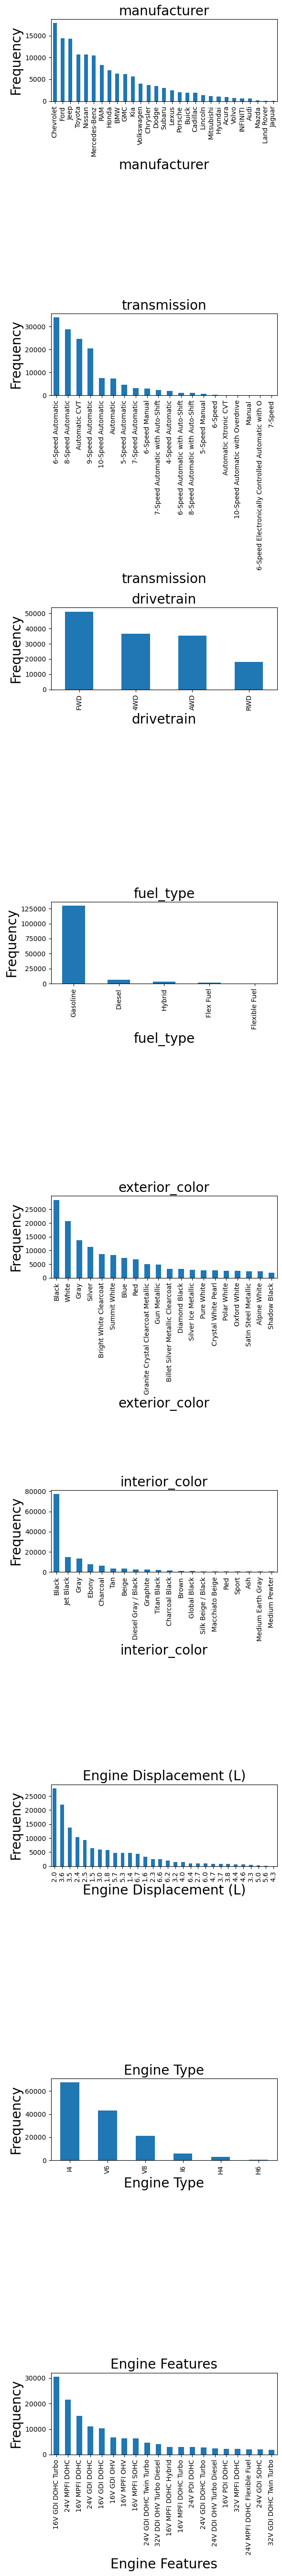

In [59]:
# Plot after cleaning data
plot_categorical_feature(cat_columns,df)

In [60]:
df.reset_index(drop=True)   #reset indexes

manufacturer  year   mileage       transmission drivetrain fuel_type  \
0             Acura  2023       6.0      Automatic CVT        FWD  Gasoline   
1             Acura  2023   10805.0     6-Speed Manual        FWD  Gasoline   
2             Acura  2023    3742.0     6-Speed Manual        FWD  Gasoline   
3             Acura  2023    5489.0      Automatic CVT        FWD  Gasoline   
4             Acura  2023    6854.0     6-Speed Manual        FWD  Gasoline   
...             ...   ...       ...                ...        ...       ...   
141477    Chevrolet  1995   21949.0  4-Speed Automatic        RWD  Gasoline   
141478         Ford  1995   12825.0  4-Speed Automatic        FWD  Gasoline   
141479        Mazda  1995  132069.0          Automatic        FWD  Gasoline   
141480   Mitsubishi  1995   29590.0  4-Speed Automatic        FWD  Gasoline   
141481   Mitsubishi  1995   42645.0     5-Speed Manual        FWD  Gasoline   

       exterior_color interior_color  accidents_or_damage  one_owner  \
0                 Red          Ebony                  0.0        0.0   
1                Gray          Ebony                  0.0        1.0   
2               White            Red                  0.0        1.0   
3               Black          Ebony                  0.0        1.0   
4               White            Red                  0.0        1.0   
...               ...            ...                  ...        ...   
141477            Red           Gray                  0.0        0.0   
141478         Silver           Gray                  0.0        1.0   
141479          White          Black                  0.0        0.0   
141480            Red          Black                  0.0        0.0   
141481          White            Tan                  0.0        1.0   

        personal_use_only  seller_rating  driver_rating  driver_reviews_num  \
0                     0.0       4.900000            4.6                   5   
1                     0.0       4.500000            4.6                   5   
2                     0.0       4.159732            4.6                   5   
3                     1.0       3.900000            4.6                   5   
4                     1.0       4.159732            4.6                   5   
...                   ...            ...            ...                 ...   
141477                1.0       2.700000            4.7                   4   
141478                0.0       3.400000            4.4                   9   
141479                0.0       3.700000            4.3                   4   
141480                1.0       4.159732            4.6                  17   
141481                1.0       4.159732            4.6                  17   

        price Engine Displacement (L) Engine Type     Engine Features  \
0       37434                     1.5          I4  16V GDI DOHC Turbo   
1       37500                     1.5          I4  16V GDI DOHC Turbo   
2       38995                     1.5          I4  16V GDI DOHC Turbo   
3       34990                     1.5          I4  16V GDI DOHC Turbo   
4       36946                     1.5          I4  16V GDI DOHC Turbo   
...       ...                     ...         ...                 ...   
141477  26994                     5.7          V8        16V MPFI OHV   
141478  18987                     3.2          V6       24V MPFI DOHC   
141479   2990                     1.6          I4       16V MPFI SOHC   
141480  32895                     3.0          V6       24V MPFI DOHC   
141481  16950                     3.0          V6       24V MPFI DOHC   

        City MPG  Highway MPG  
0           29.0         36.0  
1           26.0         36.0  
2           26.0         36.0  
3           29.0         36.0  
4           26.0         36.0  
...          ...          ...  
141477      17.0         25.0  
141478      18.0         26.0  
141479      29.0         37.0  
141480      19.0         25.0  
141481      19.

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141482 entries, 0 to 543739
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   manufacturer             141482 non-null  object 
 1   year                     141482 non-null  int64  
 2   mileage                  141482 non-null  float64
 3   transmission             141482 non-null  object 
 4   drivetrain               141482 non-null  object 
 5   fuel_type                141482 non-null  object 
 6   exterior_color           141482 non-null  object 
 7   interior_color           141482 non-null  object 
 8   accidents_or_damage      141482 non-null  float64
 9   one_owner                141482 non-null  float64
 10  personal_use_only        141482 non-null  float64
 11  seller_rating            141482 non-null  float64
 12  driver_rating            141482 non-null  float64
 13  driver_reviews_num       141482 non-null  int64  
 14  pric

In [62]:
cat_data =df.select_dtypes(include=['object'])

In [63]:
cleaned_df = pd.concat([new_num_columns, cat_data], axis=1)

In [64]:
cleaned_df= cleaned_df.dropna().reset_index(drop=True)

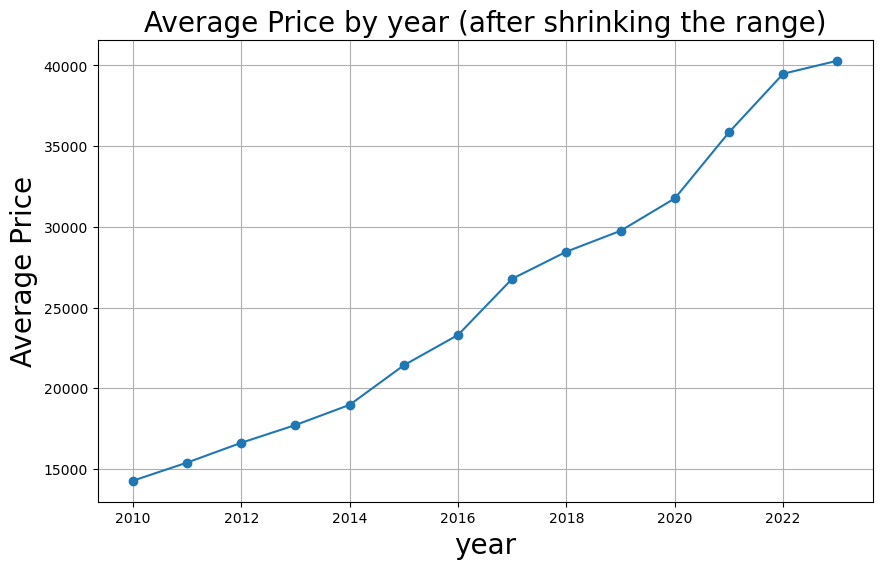

In [65]:
def plot_year_vs_price(df):
    mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
    plt.title('Average Price by year (after shrinking the range)', fontsize=20)
    plt.xlabel('year', fontsize=20)
    plt.ylabel('Average Price', fontsize=20)
    plt.grid(True)
    plt.show()

plot_year_vs_price(cleaned_df)

<a id="63"></a>
<font color = 'blue'>
### **3. Labeling Encode**

In [66]:
cat_columns= cleaned_df.select_dtypes(include=['object']).columns.tolist()
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Encode each categorical column
for col in cat_columns:
    cleaned_df[col] = label_encoder.fit_transform(cleaned_df[col])

# Your DataFrame now contains the encoded values
cleaned_df

year   mileage  accidents_or_damage  one_owner  personal_use_only  \
0      2023.0       6.0                  0.0        0.0                0.0   
1      2023.0   10805.0                  0.0        1.0                0.0   
2      2023.0    3742.0                  0.0        1.0                0.0   
3      2023.0    5489.0                  0.0        1.0                1.0   
4      2023.0    6854.0                  0.0        1.0                1.0   
...       ...       ...                  ...        ...                ...   
79239  2010.0  145670.0                  0.0        0.0                1.0   
79240  2010.0  112020.0                  0.0        0.0                1.0   
79241  2010.0  121595.0                  0.0        0.0                1.0   
79242  2010.0  140878.0                  0.0        0.0                1.0   
79243  2010.0  115743.0                  0.0        0.0                1.0   

       seller_rating  driver_rating  driver_reviews_num    price  City MPG  \
0           4.900000            4.6                 5.0  37434.0      29.0   
1           4.500000            4.6                 5.0  37500.0      26.0   
2           4.159732            4.6                 5.0  38995.0      26.0   
3           3.900000            4.6                 5.0  34990.0      29.0   
4           4.159732            4.6                 5.0  36946.0      26.0   
...              ...            ...                 ...      ...       ...   
79239       4.800000            4.8                19.0   6995.0      18.0   
79240       4.159732            4.8                19.0   9689.0      18.0   
79241       4.159732            4.8                19.0   9495.0      18.0   
79242       4.200000            4.8                48.0  11995.0      16.0   
79243       3.600000            4.8                48.0   8999.0      18.0   

       Highway MPG  manufacturer  transmission  drivetrain  fuel_type  \
0             36.0             0            17           2          3   
1             36.0             0             9           2          3   
2             36.0             0             9           2          3   
3             36.0             0            17           2          3   
4             36.0             0             9           2          3   
...            ...           ...           ...         ...        ...   
79239         27.0            28             6           2          3   
79240         27.0            28             6           2          3   
79241         27.0            28             6           2          3   
79242         22.0            28             6           1          3   
79243         27.0            28             6           2          3   

       exterior_color  interior_color  Engine Displacement (L)  Engine Type  \
0                  13               7                        1            2   
1                   8               7                        1            2   
2                  19              15                        1            2   
3                   2               7                        1            2   
4                  19              15                        1            2   
...               ...             ...                      ...          ...   
79239               2               2                       10            3   
79240              19              18                       10            3   
79241               3              18                       10            3   
79242              13              18                       10            3   
79243              13               1                       10            3   

       Engine Features  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
79239               14  
79240               14  
79241               14  
79242               14  
79243               14  

[79244 r

* Checking the null values on our cleaned dataset

In [67]:
cleaned_df.isnull().sum()

year                       0
mileage                    0
accidents_or_damage        0
one_owner                  0
personal_use_only          0
seller_rating              0
driver_rating              0
driver_reviews_num         0
price                      0
City MPG                   0
Highway MPG                0
manufacturer               0
transmission               0
drivetrain                 0
fuel_type                  0
exterior_color             0
interior_color             0
Engine Displacement (L)    0
Engine Type                0
Engine Features            0
dtype: int64

In [68]:
cleaned_df['accidents_or_damage'].value_counts()

0.0    79244
Name: accidents_or_damage, dtype: int64

In [69]:
cleaned_df=cleaned_df.drop(['accidents_or_damage'], axis=1)

In [70]:
df.shape

(141482, 20)

<a id="64"></a>
<font color = 'blue'>
### **4. Correlation Matrix**

The **`correlation matrix`** shows us the correlation coefficients between variables. 
* If the correlation coefficient is close to 1, it appears a strong positive relationship. That means, if one variable increases, the other tends to increase as well.
* If the correlation coefficient is close to -1, it appears a strong negative relationship. That means, if one variable decreases, the other tends to decrease as well.
* If the correlation coefficient is close to 0, it appears a weak or no linear relationship between two variables.

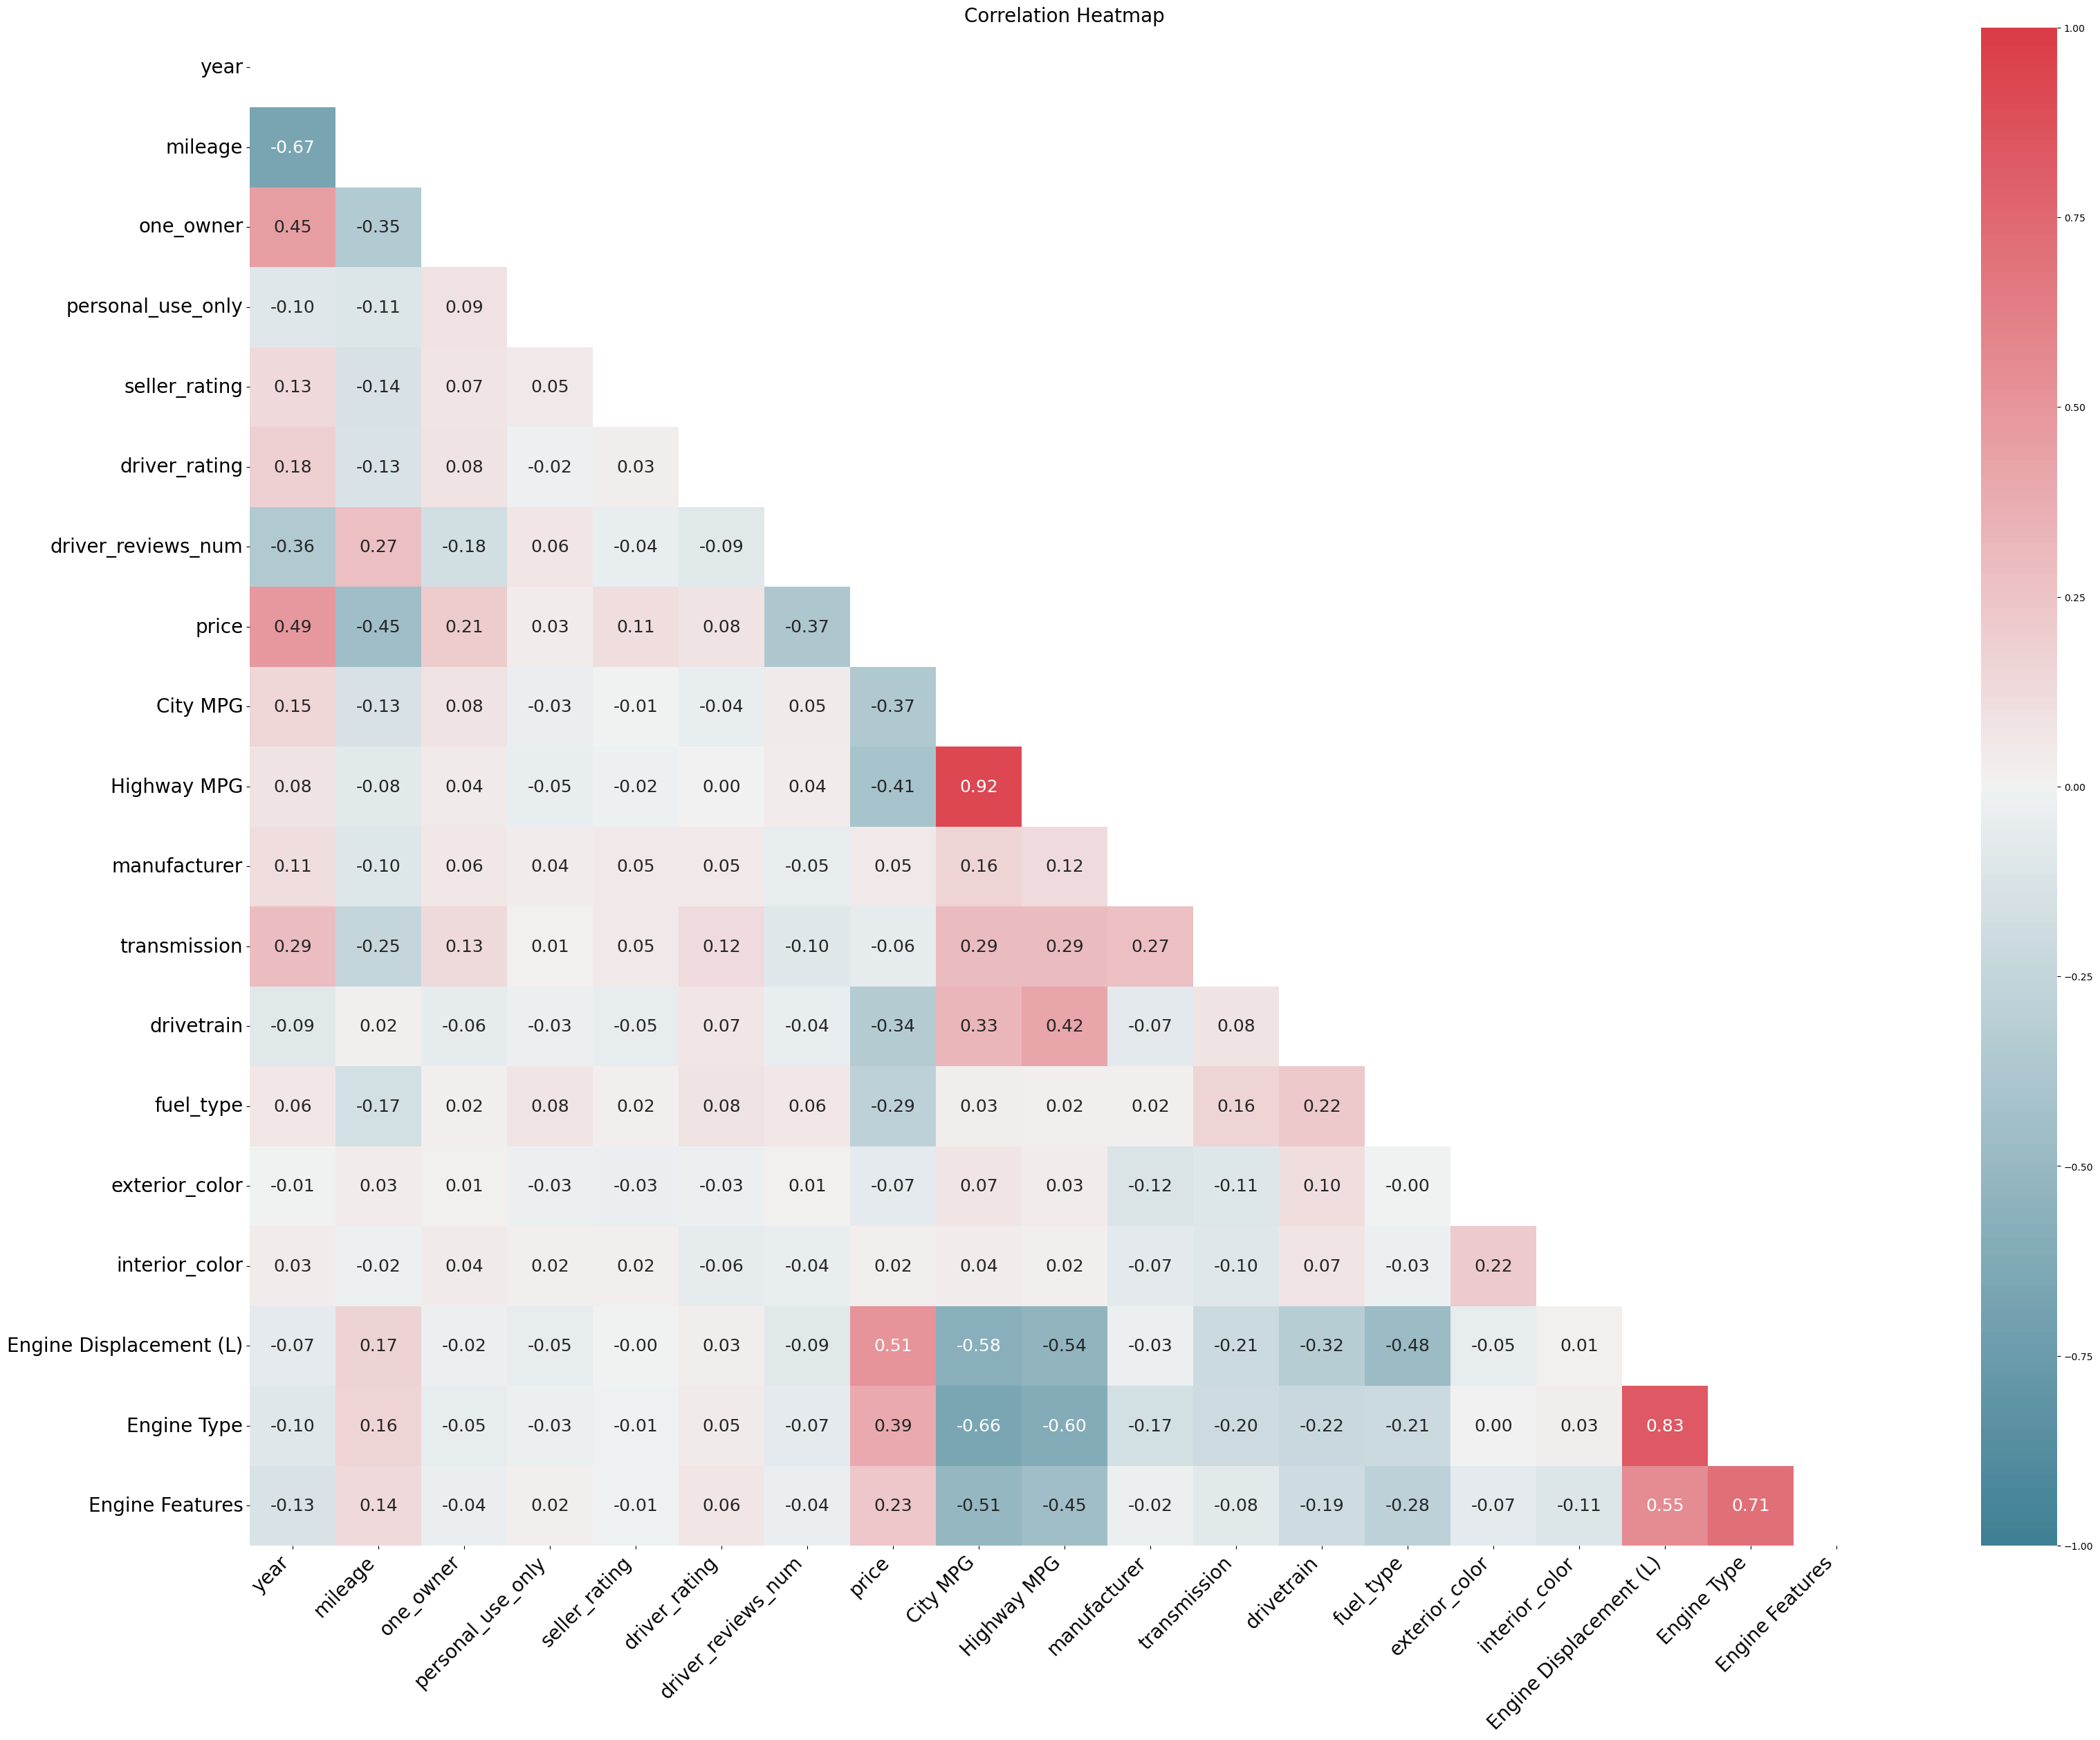

In [71]:
heat_map(cleaned_df, cleaned_df.columns.tolist())

<div class="alert alert-block alert-info"> <b>Tip:</b> We can see there are some correlated features. We need to select the useful feature carefully to get optimize our model as much as possible </div>

Our target is `Price`, which is strong relationship to many features. However, the variables outside our target exhibit multicollinearity, such as: City MPG - Highway MPG, year-one owner, and Engine features-Engine Type, Engine Displacement(L), Engine Type, City, Highway MPG, etc.

We can also use **`variance_inflation_factor`** to diagnose the multicollinearity. Typically, a high VIF value (usually greater than 10) is an indicator of significant multicollinearity. It means that the variance of the coefficient estimate for that variable is 10 times larger than it would be if there were no multicollinearity. 

In [72]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(x):
    vif = pd.DataFrame()
    vif["variables"] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif

So, let's  drop some features: 

In [73]:
df2=cleaned_df.drop(['Engine Type', 'Engine Features','City MPG','interior_color', 'personal_use_only', 'driver_rating','seller_rating'], axis =1)
df2

year   mileage  one_owner  driver_reviews_num    price  Highway MPG  \
0      2023.0       6.0        0.0                 5.0  37434.0         36.0   
1      2023.0   10805.0        1.0                 5.0  37500.0         36.0   
2      2023.0    3742.0        1.0                 5.0  38995.0         36.0   
3      2023.0    5489.0        1.0                 5.0  34990.0         36.0   
4      2023.0    6854.0        1.0                 5.0  36946.0         36.0   
...       ...       ...        ...                 ...      ...          ...   
79239  2010.0  145670.0        0.0                19.0   6995.0         27.0   
79240  2010.0  112020.0        0.0                19.0   9689.0         27.0   
79241  2010.0  121595.0        0.0                19.0   9495.0         27.0   
79242  2010.0  140878.0        0.0                48.0  11995.0         22.0   
79243  2010.0  115743.0        0.0                48.0   8999.0         27.0   

       manufacturer  transmission  drivetrain  fuel_type  exterior_color  \
0                 0            17           2          3              13   
1                 0             9           2          3               8   
2                 0             9           2          3              19   
3                 0            17           2          3               2   
4                 0             9           2          3              19   
...             ...           ...         ...        ...             ...   
79239            28             6           2          3               2   
79240            28             6           2          3              19   
79241            28             6           2          3               3   
79242            28             6           1          3              13   
79243            28             6           2          3              13   

       Engine Displacement (L)  
0                            1  
1                            1  
2                            1  
3                            1  
4                            1  
...                        ...  
79239                       10  
79240                       10  
79241                       10  
79242                       10  
79243                       10  

[79244 rows x 12 columns]

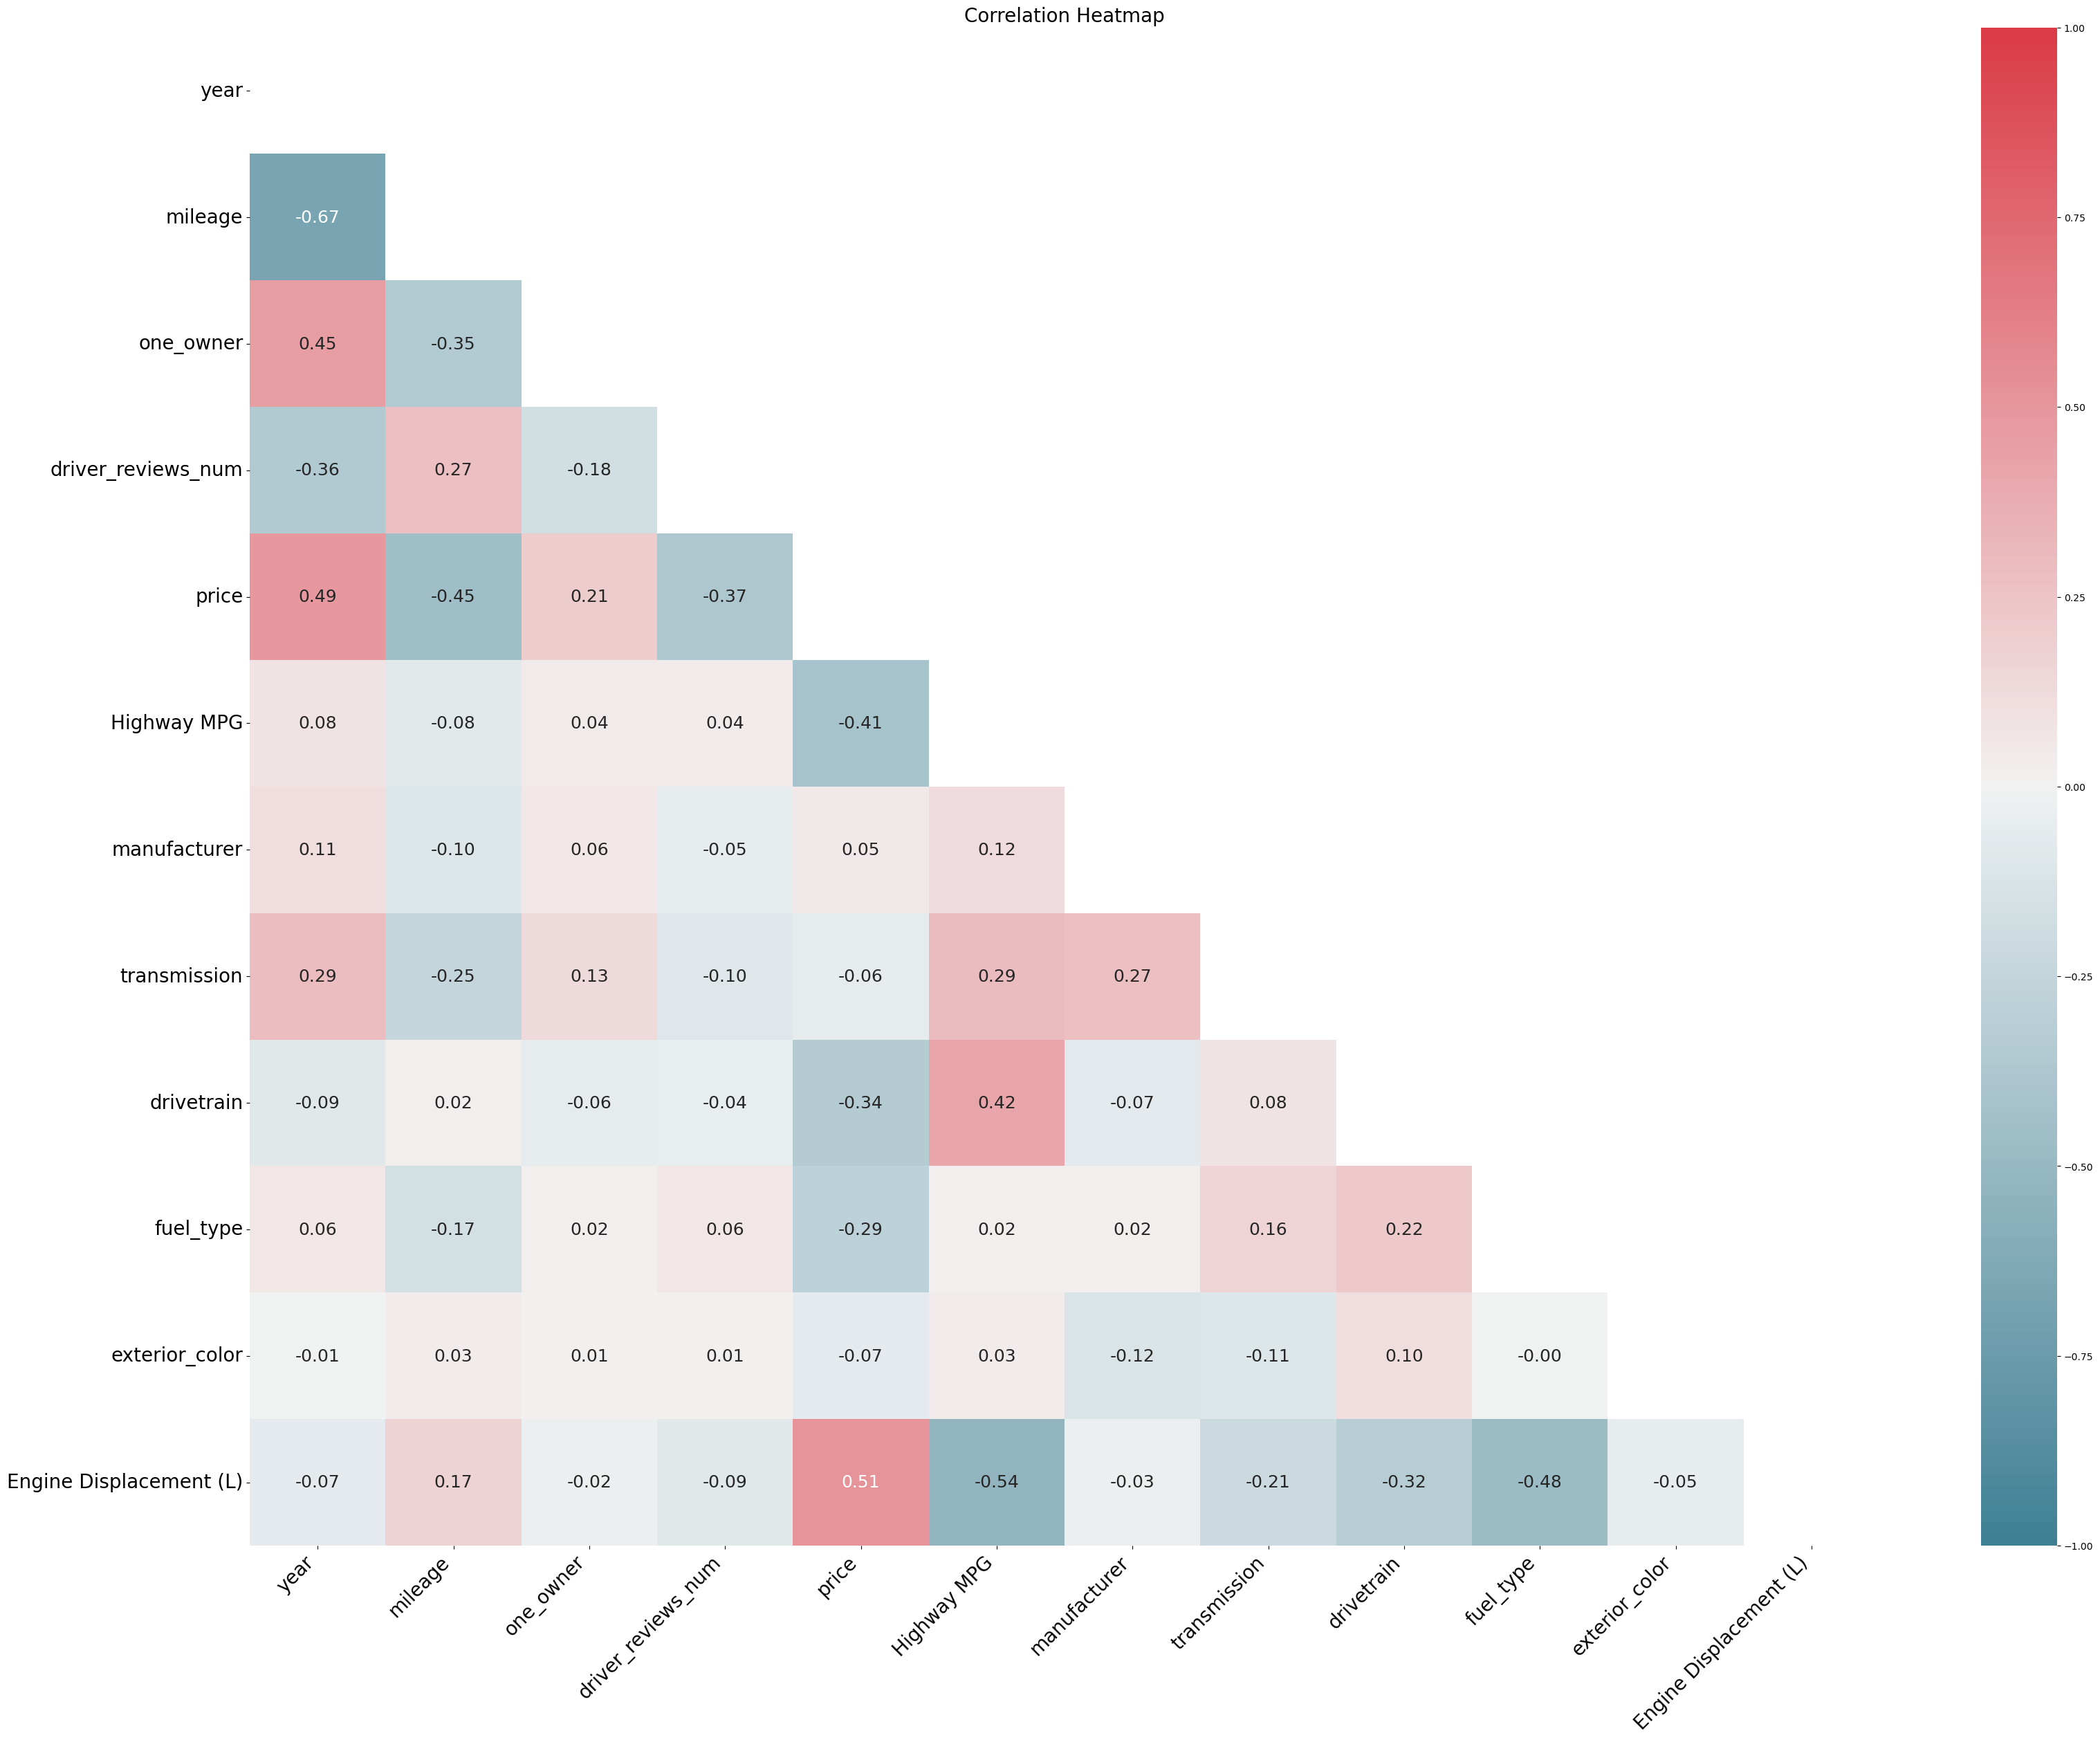

In [74]:
heat_map(df2, cleaned_df.columns.tolist())

In [75]:
calc_vif(df2.drop('price', axis=1))

variables         VIF
0                      year  166.638419
1                   mileage    4.442221
2                 one_owner    2.971453
3        driver_reviews_num    2.552185
4               Highway MPG   70.804174
5              manufacturer    4.504675
6              transmission    7.595793
7                drivetrain    3.798618
8                 fuel_type   37.014558
9            exterior_color    3.241470
10  Engine Displacement (L)    5.801891

These are the important features that we will use to fit our models:
**year,
mileage	,
one_owner	,
driver_reviews_num,	
Highway MPG	,
manufacturer,	
transmission,	
drivetrain,	
fuel_type,	
exterior_color,	
Engine Displacement (L),** in dataframe `df2`

<a id="7"></a>
<font color = 'blue'>
## **7. Data Splitting**


In [76]:
X = df2.drop('price', axis =1)
Y= df2['price']

In [77]:
random_state=0

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=random_state)

In [79]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(55470, 11) (23774, 11) (55470,) (23774,)


<a id="8"></a>
<font color = 'blue'>
## **8. Models Evaluations and Predictions**
   

<a id="81"></a>
<font color = 'blue'>
### **8.1 Multiple Linear Regression**
   

<a id="811"></a>
<font color = 'blue'>
* #### **8.1.1. Using Sequential Feature Selection for the Linear Regression**
      

Let's try the **Sequential Feature Selection** method to choose 10-15 significant variables for our model.

Learn more: [Sequential Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance) (Forward/ Backward)


In [80]:
lasso_reg=Lasso(fit_intercept= True, random_state = random_state)
sfs = SequentialFeatureSelector(lasso_reg, direction ='forward',  n_features_to_select=8).fit(X_train, y_train)

In [81]:
best_features=sfs.get_feature_names_out()
best_features

array(['year', 'mileage', 'driver_reviews_num', 'Highway MPG',
       'transmission', 'drivetrain', 'fuel_type',
       'Engine Displacement (L)'], dtype=object)

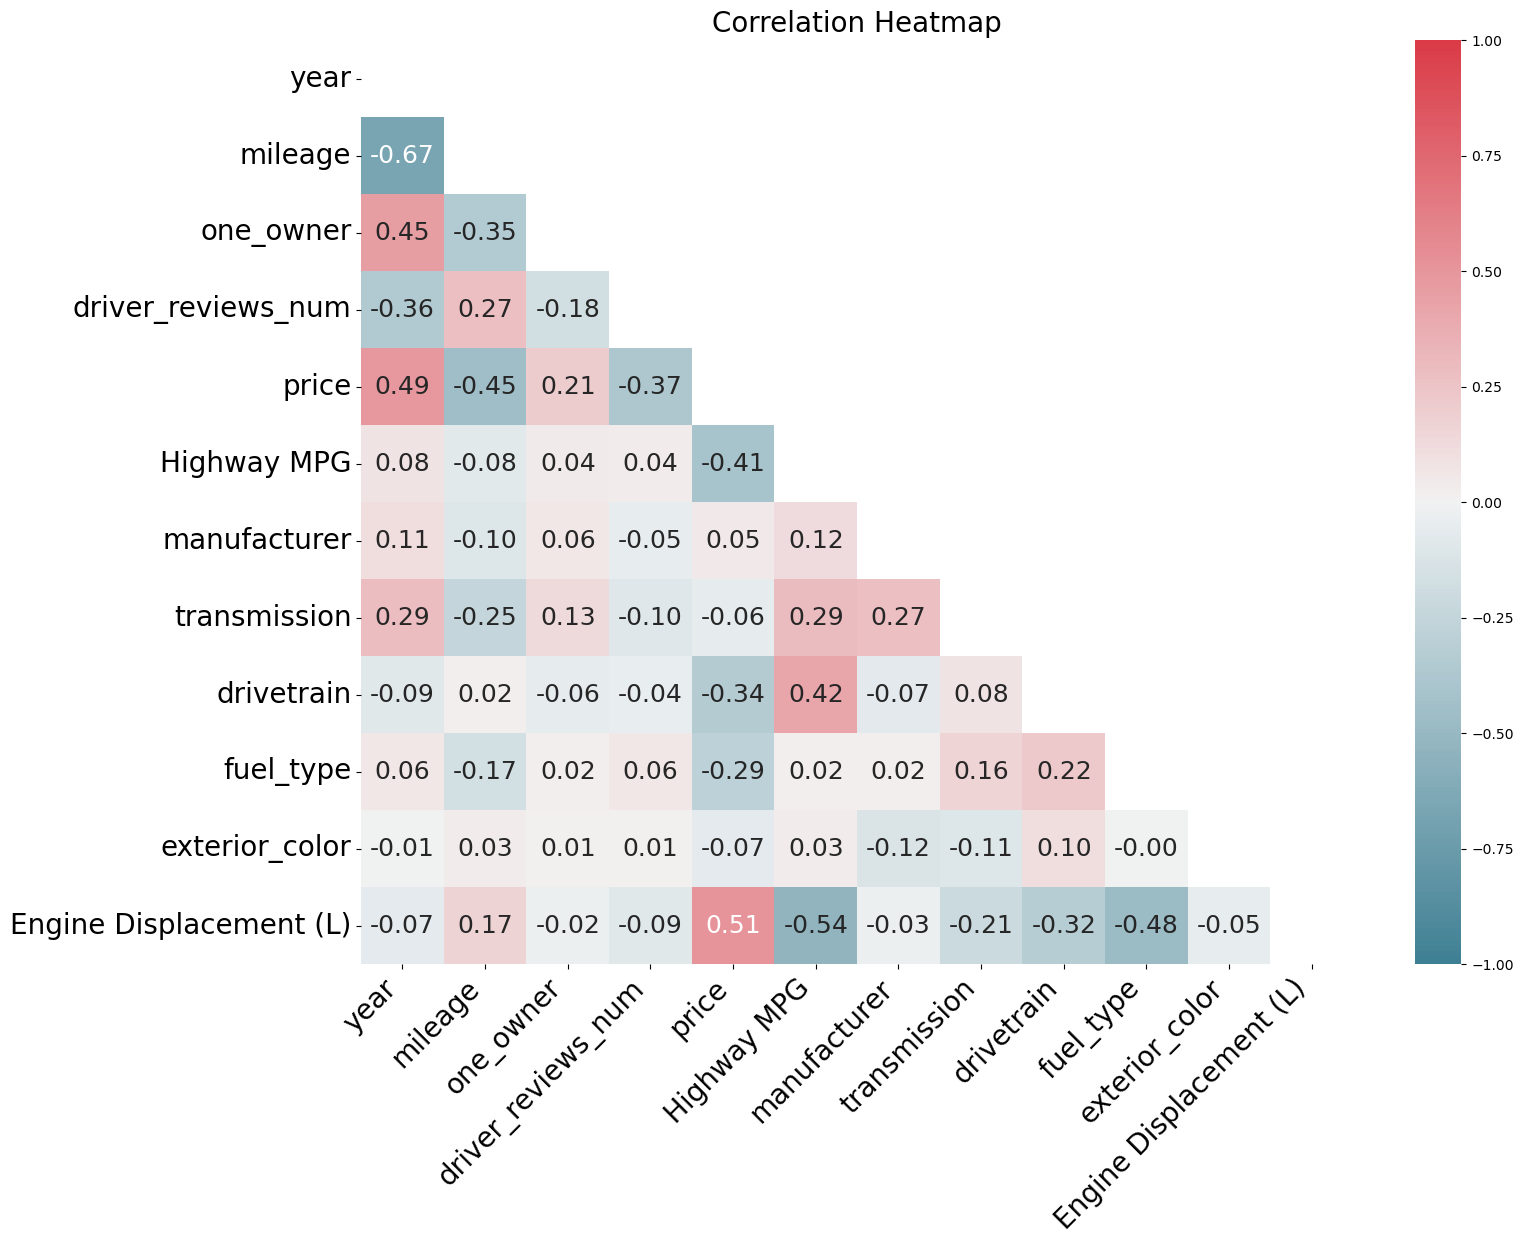

In [82]:
heat_map(df2, best_features)

**We will use these features to fit our models**

In [83]:
metrics_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R2']) # these metrics are used to evaluate our models

In [84]:
X_train=X_train[best_features]
X_test=X_test[best_features]

In [85]:
LR = LinearRegression(fit_intercept=True)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

In [86]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model 1 MAE:", mae)
print("Model 1 MSE:", mse)
print("Model 1 R2:", r2)

Model 1 MAE: 5107.726806916584
Model 1 MSE: 44218544.21731075
Model 1 R2: 0.6748814955177959


In [87]:
# Add a constant term to your X_train
X_train1 = sm.add_constant(X_train)

# Create a linear regression model
model = sm.OLS(y_train, X_train1)

# Fit the model
results = model.fit()

# Display the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                 1.447e+04
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:36:57   Log-Likelihood:            -5.6678e+05
No. Observations:               55470   AIC:                         1.134e+06
Df Residuals:                   55461   BIC:                         1.134e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

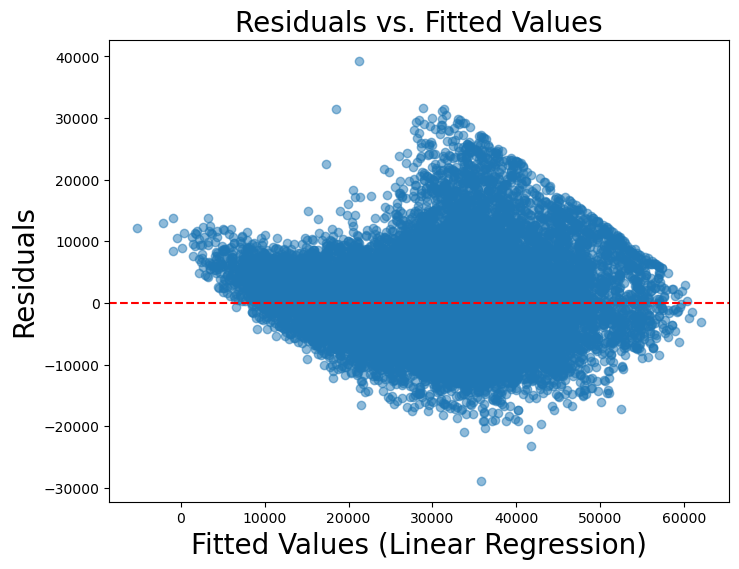

In [88]:
# Create a scatterplot of fitted values vs. residuals
residuals = y_test - y_pred  # Calculate the residuals

# Create a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Fitted Values', fontsize=20)
plt.xlabel('Fitted Values (Linear Regression)', fontsize=20)
plt.ylabel('Residuals', fontsize=20)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='--')

plt.show()

This indicates that there may be a **violation of the assumption of linearity** in our linear regression model. This pattern suggests that the relationship between the independent variables (**features**) and the dependent variable (`price`) is not adequately captured by a simple linear model.

So, we need to try **polynomial regression**:

In [89]:
# TRAINING ERROR PER DEGREE
train_rmse_errors = []
# TEST ERROR PER DEGREE
test_rmse_errors = []
#MODEL and METRIC COLLECTION
model_collection =[]
mae_collection =[]
mse_collection =[]
r2_collection  =[]
y_test_collection=[]

for d in range(1,5):
    # CREATE POLY DATA SET FOR DEGREE "d"
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)

    # SPLIT THIS NEW POLY DATA SET
    X_train1, X_test1, y_train1, y_test1 = train_test_split(poly_features, Y, test_size=0.3, random_state=random_state)

    # TRAIN ON THIS NEW POLY SET
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train1,y_train1)
    model_collection.append(model)

    # PREDICT ON BOTH TRAIN AND TEST
    train_pred = model.predict(X_train1)
    test_pred = model.predict(X_test1)
    y_test_collection.append(test_pred)
    
    # Calculate Errors

    # Errors on Train Set
    train_RMSE = np.sqrt(mean_squared_error(y_train1,train_pred))

    # Errors on Test Set
    test_RMSE = np.sqrt(mean_squared_error(y_test1,test_pred))

    # Append errors to lists for plotting later
    mae_collection.append( mean_absolute_error(y_test1, test_pred))
    mse_collection.append( mean_squared_error(y_test1, test_pred))
    r2_collection .append( r2_score(y_test1, test_pred))

    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)

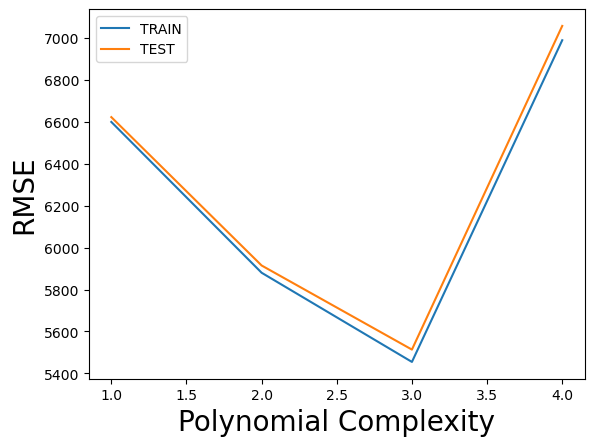

In [90]:
# Plot the RMSE values for degrees 1, 2,3,4
plt.plot(range(1, 5), train_rmse_errors[:5], label='TRAIN')
plt.plot(range(1, 5), test_rmse_errors[:5], label='TEST')
plt.xlabel("Polynomial Complexity", fontsize=20)
plt.ylabel("RMSE", fontsize=20)
plt.legend()
plt.show()

In [91]:
print(model_collection)
print(mae_collection )
print(mse_collection )
print(r2_collection  )

[LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()]
[5091.3731622853165, 4495.828896823635, 4196.820717227649, 5256.416215758709]
[43860366.06672207, 34984983.749280795, 30399419.00933599, 49813594.965754576]
[0.6775150138011048, 0.7427715951026816, 0.7764871318044426, 0.633743675084441]


We can see that the **polynomial degree 3** could be **the best** since the test error start overfitting at or after degree 4.
So, let create and refit 

In [92]:
best_degree_index = 3-1
mae =mae_collection[best_degree_index]
mse = mse_collection[best_degree_index]
r2 =r2_collection[best_degree_index]

print("The Polynomial Regression Model MAE:", mae)
print("Polynomial Regression Model MSE:", mse)
print("Polynomial Regression Model R2:", r2)

The Polynomial Regression Model MAE: 4196.820717227649
Polynomial Regression Model MSE: 30399419.00933599
Polynomial Regression Model R2: 0.7764871318044426


In [93]:
# Append metrics to the DataFrame
metrics_df = metrics_df.append({'Model': f'Degree {best_degree_index+1} - Polynomial Reg.', 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)
metrics_df

/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_27368/1313536453.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': f'Degree {best_degree_index+1} - Polynomial Reg.', 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)


Model          MAE           MSE        R2
0  Degree 3 - Polynomial Reg.  4196.820717  3.039942e+07  0.776487

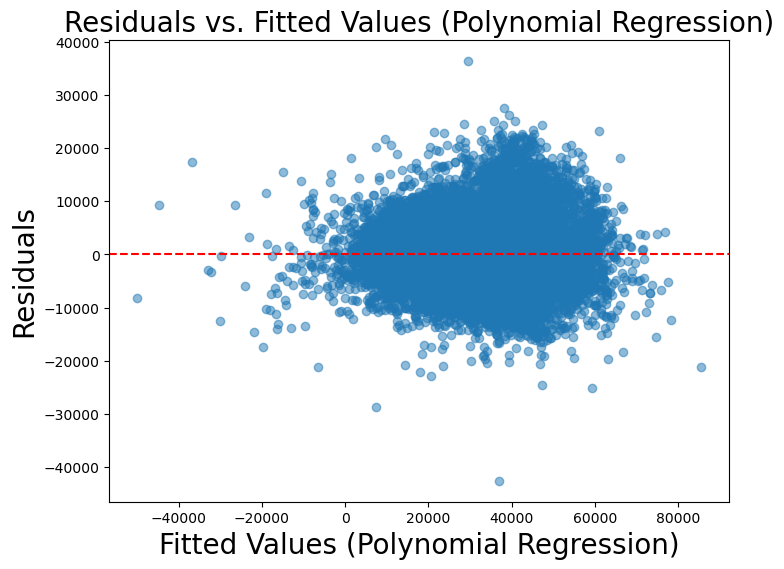

In [94]:
y_pred = y_test_collection[best_degree_index]

# Calculate the residuals
residuals_poly = y_test1 - y_pred

# Create a scatterplot of fitted values vs. residuals
plt.figure(figsize=(8, 6))
plt.scatter(test_pred, residuals_poly, alpha=0.5)
plt.title('Residuals vs. Fitted Values (Polynomial Regression)', fontsize=20)  # Adjust fontsize as needed
plt.xlabel('Fitted Values (Polynomial Regression)', fontsize=20)  # Adjust fontsize as needed
plt.ylabel('Residuals', fontsize=20)  # Adjust fontsize as needed

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='--')

plt.show()


We can see that the plot does not appear a pattern. That means, there is a linear relationship among variables in polynomial regression.

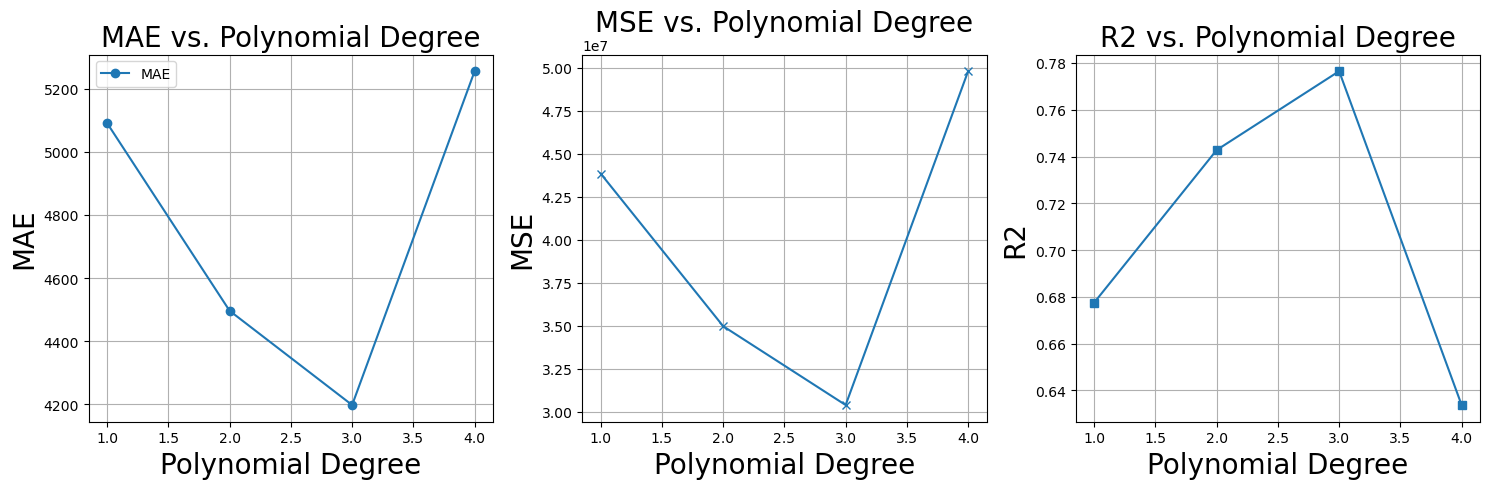

In [95]:
# Create a list of degrees for the x-axis (you can adjust this as needed)
degrees = [1, 2, 3, 4]  

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Create a scatter plot for MAE
ax1.plot(degrees, mae_collection, label='MAE', marker='o', linestyle='-')
ax1.set_xlabel("Polynomial Degree", fontsize=20)
ax1.set_ylabel("MAE", fontsize=20)
ax1.set_title("MAE vs. Polynomial Degree", fontsize=20)
ax1.grid(True)

# Create a scatter plot for MSE
ax2.plot(degrees, mse_collection, label='MSE', marker='x', linestyle='-')
ax2.set_xlabel("Polynomial Degree", fontsize=20)
ax2.set_ylabel("MSE", fontsize=20)
ax2.set_title("MSE vs. Polynomial Degree", fontsize=20)
ax2.grid(True)

# Create a scatter plot for R2
ax3.plot(degrees, r2_collection, label='R2', marker='s', linestyle='-')
ax3.set_xlabel("Polynomial Degree", fontsize=20)
ax3.set_ylabel("R2", fontsize=20)
ax3.set_title("R2 vs. Polynomial Degree", fontsize=20)
ax3.grid(True)

# Add a legend to one of the subplots
ax1.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

<a id="82"></a>
<font color = 'blue'>
   ### **8.2 Decision Tree**
   

<a id="821"></a>
<font color = 'blue'>
* #### **8.2.1. A Pruned Tree**: Pruning reduces the size of decision trees by removing parts of the tree that do not provide power to classify instances. Decision trees are the most susceptible out of all the machine learning algorithms to overfitting and effective pruning can reduce this likelihood.
      

In [96]:
best_churn_tree = DecisionTreeRegressor(criterion='absolute_error',max_depth=4)
#best_churn_tree = DecisionTreeRegressor(criterion='absolute_error',max_depth=5, min_samples_split=10)

best_churn_tree.fit(X_train, y_train)

y_pred = best_churn_tree.predict(X_test)
score = mean_absolute_error(y_test, y_pred)
print(score)

5530.8134937326495


In [97]:

ccp_path = best_churn_tree.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,random_state=0,shuffle=True)

grid = skm.GridSearchCV(best_churn_tree,{'ccp_alpha': ccp_path.ccp_alphas},refit=True,cv=kfold, n_jobs=-1,scoring='neg_mean_absolute_error',return_train_score=True) 
grid.fit(X_train, y_train)
print(f"Best Cross-Validation Score: {grid.best_score_}")

Best Cross-Validation Score: -5512.98769605192


In [98]:
best_tree = grid.best_estimator_ 
print(best_tree)
print(f"Best Tree Depth: {best_tree.get_depth()}")

DecisionTreeRegressor(criterion='absolute_error', max_depth=4)
Best Tree Depth: 4


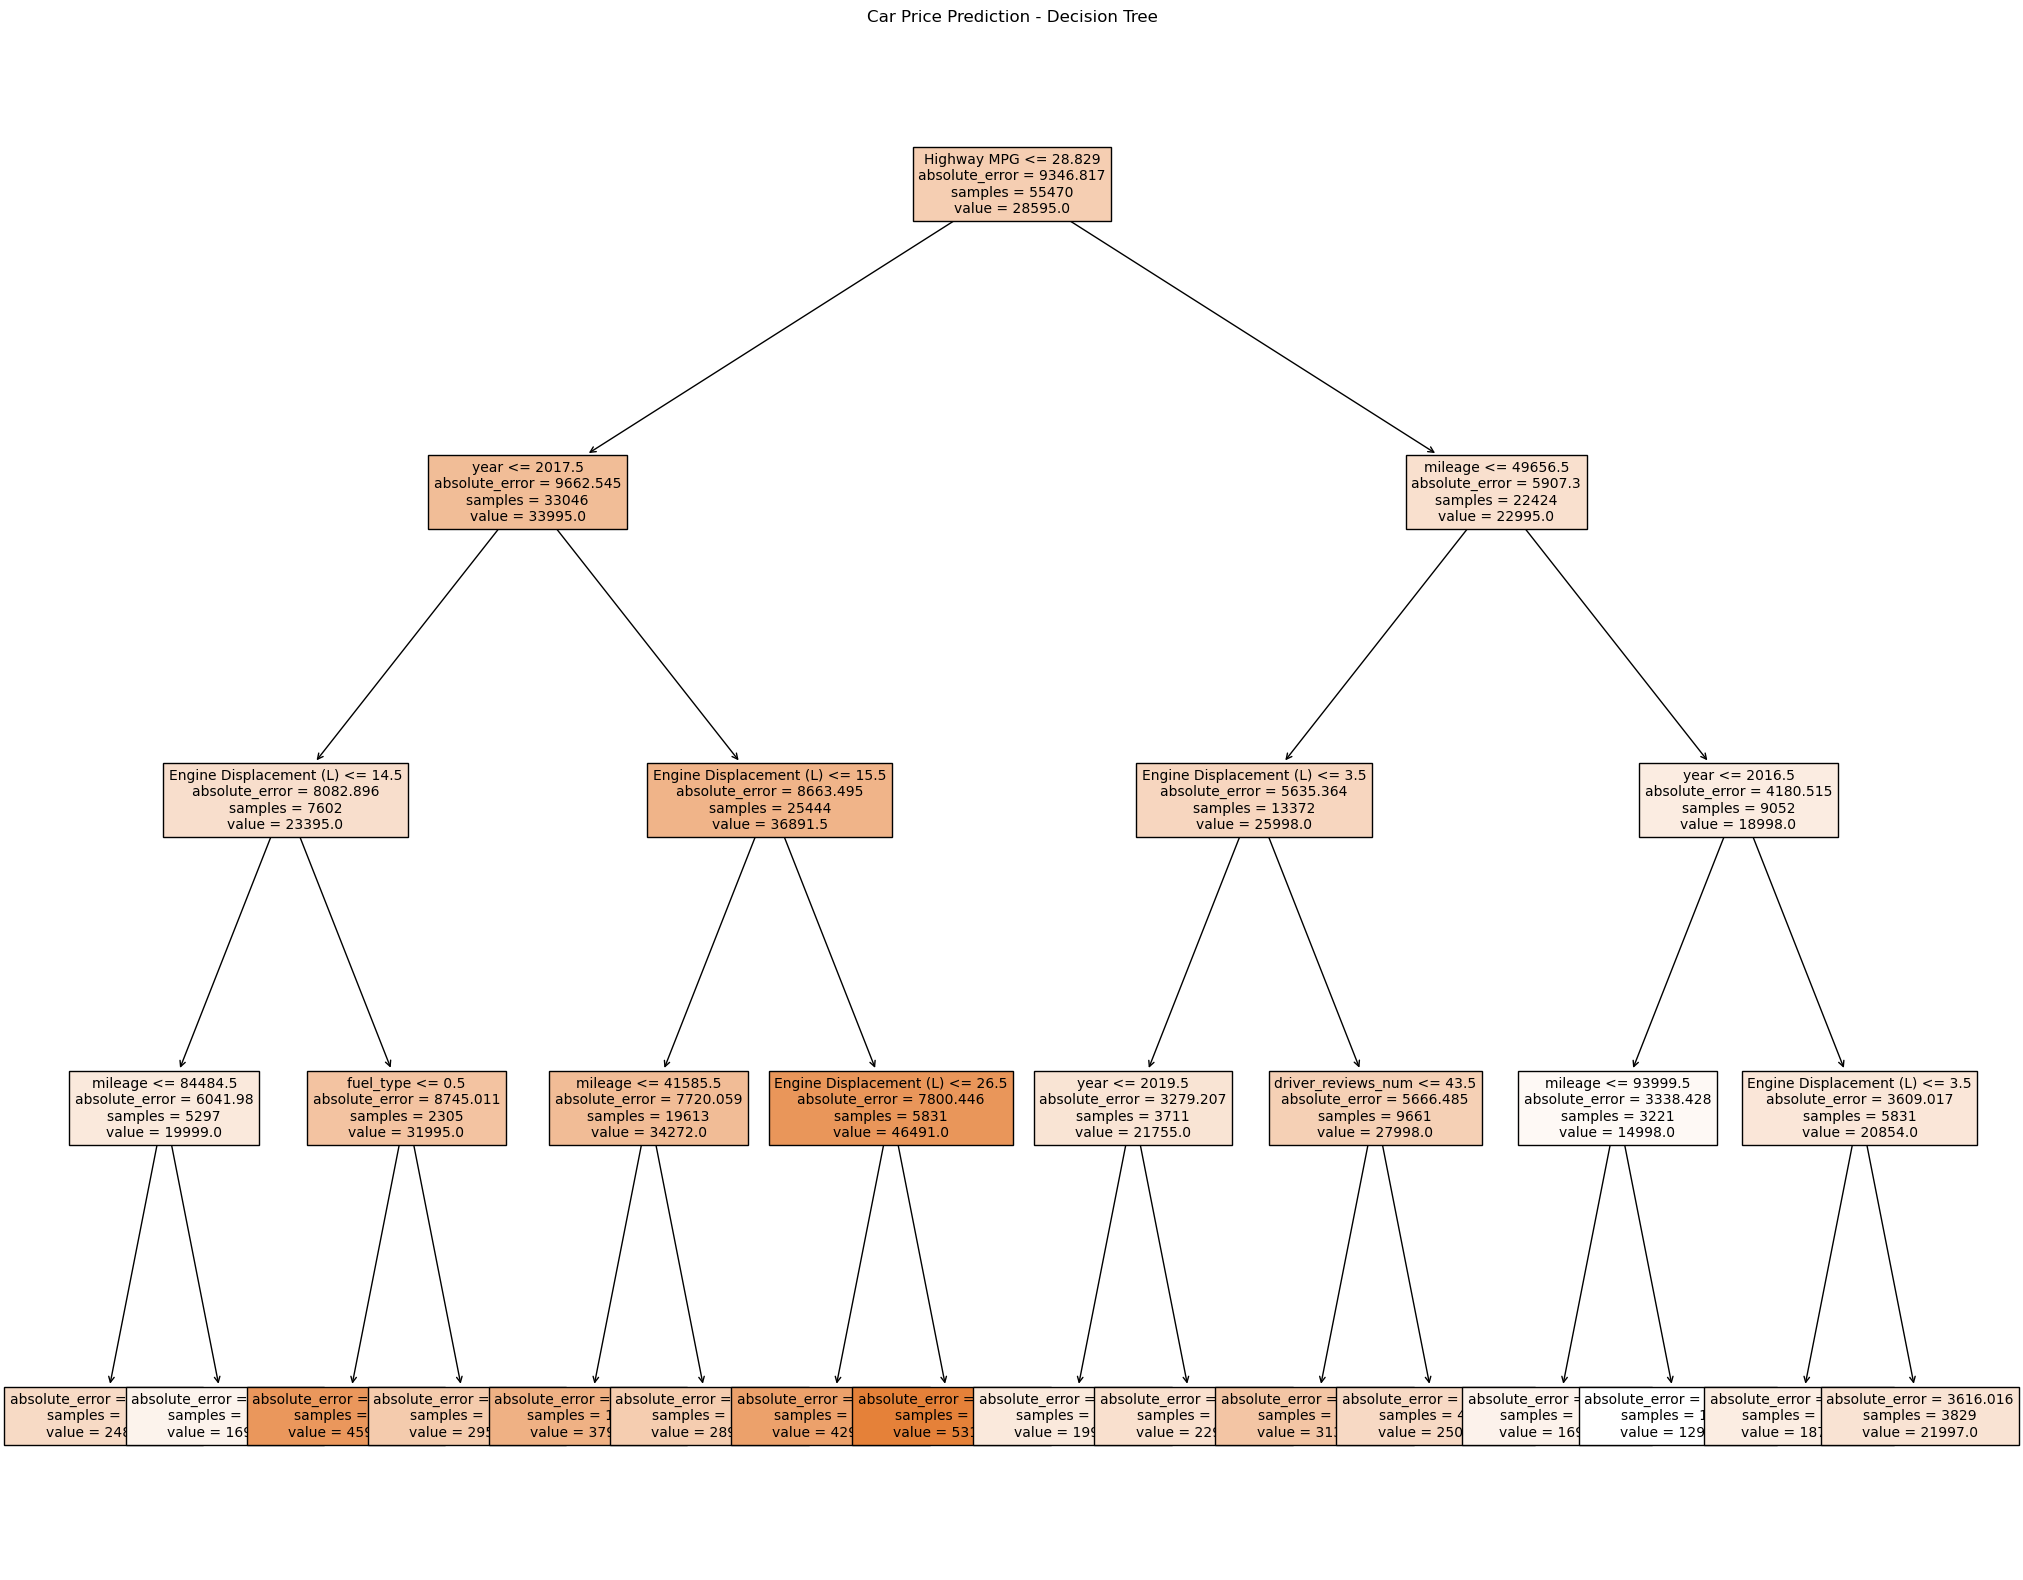

|--- Highway MPG <= 28.83
|   |--- year <= 2017.50
|   |   |--- Engine Displacement (L) <= 14.50
|   |   |   |--- mileage <= 84484.50
|   |   |   |   |--- value: [24824.50]
|   |   |   |--- mileage >  84484.50
|   |   |   |   |--- value: [16900.00]
|   |   |--- Engine Displacement (L) >  14.50
|   |   |   |--- fuel_type <= 0.50
|   |   |   |   |--- value: [45990.00]
|   |   |   |--- fuel_type >  0.50
|   |   |   |   |--- value: [29533.00]
|   |--- year >  2017.50
|   |   |--- Engine Displacement (L) <= 15.50
|   |   |   |--- mileage <= 41585.50
|   |   |   |   |--- value: [37990.00]
|   |   |   |--- mileage >  41585.50
|   |   |   |   |--- value: [28950.00]
|   |   |--- Engine Displacement (L) >  15.50
|   |   |   |--- Engine Displacement (L) <= 26.50
|   |   |   |   |--- value: [42996.00]
|   |   |   |--- Engine Displacement (L) >  26.50
|   |   |   |   |--- value: [53135.00]
|--- Highway MPG >  28.83
|   |--- mileage <= 49656.50
|   |   |--- Engine Displacement (L) <= 3.50
|   |   | 

In [99]:
# Plot the decision tree with clearer visualization
plt.figure(figsize=(25, 20))  # Adjust the figure size

plot_tree(
    best_tree,
    filled=True,  # Fill nodes with color
    feature_names=X_train.columns,  # Provide feature names for labeling
    fontsize=10,  # Adjust font size
)

plt.title("Car Price Prediction - Decision Tree")
plt.show()
print(export_text(best_tree,feature_names=list(X_train.columns),show_weights=True))

In [100]:
y_pred=best_tree.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [101]:
# Append metrics to the DataFrame
metrics_df = metrics_df.append({'Model': type(best_tree).__name__, 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)
metrics_df

/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_27368/2408551179.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': type(best_tree).__name__, 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)


Model          MAE           MSE        R2
0  Degree 3 - Polynomial Reg.  4196.820717  3.039942e+07  0.776487
1       DecisionTreeRegressor  5530.813494  5.393986e+07  0.603405

<a id="83"></a>
<font color = 'blue'>
### **8.3. Ensemble Method: Random Forest Regression**
   

In [102]:
param_grid = {'bootstrap': [True],'n_estimators':[ 100,300], "max_depth":[4], 'criterion': ['squared_error'], 'ccp_alpha':[0.1]}
kfold = skm.KFold(5,random_state=0,shuffle=True)
grid_search = skm.GridSearchCV(RandomForestRegressor( random_state=0,n_jobs = -1),param_grid, cv=kfold,return_train_score=True,scoring='neg_mean_absolute_error')

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'bootstrap': [True], 'ccp_alpha': [0.1],
                         'criterion': ['squared_error'], 'max_depth': [4],
                         'n_estimators': [100, 300]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [103]:
model = grid_search.best_estimator_
model

RandomForestRegressor(ccp_alpha=0.1, max_depth=4, n_estimators=300, n_jobs=-1,
                      random_state=0)

In [104]:
grid_search.best_score_

-5438.333548442887

In [105]:
y_pred=model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [106]:
# Append metrics to the DataFrame
metrics_df = metrics_df.append({'Model': type(model).__name__, 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)
metrics_df

/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_27368/2936458440.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': type(model).__name__, 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)


Model          MAE           MSE        R2
0  Degree 3 - Polynomial Reg.  4196.820717  3.039942e+07  0.776487
1       DecisionTreeRegressor  5530.813494  5.393986e+07  0.603405
2       RandomForestRegressor  5485.646948  5.206226e+07  0.617210

<a id="84"></a>
<font color = 'blue'>
   ### **8.4. Ensemble Method: Gradient Boosting Regression**
   

In [107]:
param_grid = {'learning_rate': [0.1],'n_estimators':[ 100], "max_depth":[4], 'criterion': ['squared_error']}
kfold = skm.KFold(5,random_state=0,shuffle=True)
grid_search = skm.GridSearchCV(GradientBoostingRegressor(  random_state=0), param_grid, cv=kfold, n_jobs=-1,scoring='neg_mean_absolute_error')

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best learning rate
best_learning_rate = grid_search.best_params_['learning_rate']

# Access the best regressor
best_boosting_regressor = grid_search.best_estimator_

# Access the best hyperparameters
best_hyperparameters = grid_search.best_params_

In [108]:
best_boosting_regressor

GradientBoostingRegressor(criterion='squared_error', max_depth=4,
                          random_state=0)

In [109]:
y_pred = best_boosting_regressor.predict(X_test)

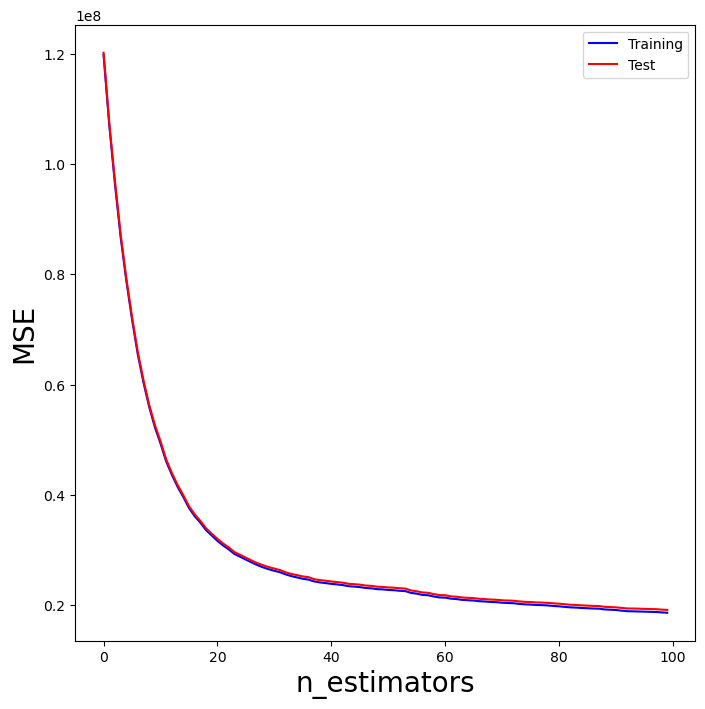

In [110]:
test_error = np.zeros_like(best_boosting_regressor.train_score_)

for idx, y_ in enumerate(best_boosting_regressor.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(best_boosting_regressor.train_score_.shape[0]) 

ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,best_boosting_regressor.train_score_, 'b',label='Training')
ax.plot(plot_idx, test_error ,'r',label='Test') 
ax.set_xlabel("n_estimators", fontsize=20)
ax.set_ylabel("MSE", fontsize=20)
ax.legend();

In [111]:
grid_search.best_score_

-3259.007627393795

In [112]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [113]:
# Append metrics to the DataFrame
metrics_df = metrics_df.append({'Model': type(best_boosting_regressor).__name__, 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)
metrics_df

/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_27368/890018022.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': type(best_boosting_regressor).__name__, 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)


Model          MAE           MSE        R2
0  Degree 3 - Polynomial Reg.  4196.820717  3.039942e+07  0.776487
1       DecisionTreeRegressor  5530.813494  5.393986e+07  0.603405
2       RandomForestRegressor  5485.646948  5.206226e+07  0.617210
3   GradientBoostingRegressor  3251.007182  1.917146e+07  0.859041

In [114]:
# Get feature importances and corresponding feature names
feature_importances = best_boosting_regressor.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

                   Feature  Importance
7  Engine Displacement (L)    0.247365
1                  mileage    0.180748
3              Highway MPG    0.167876
0                     year    0.142494
2       driver_reviews_num    0.095397
5               drivetrain    0.090757
4             transmission    0.069051
6                fuel_type    0.006313


In [115]:
feature_imp = pd.DataFrame( {'importance':best_boosting_regressor.feature_importances_}, index=X_train.columns.tolist())
sorted_feature_imp= feature_imp.sort_values(by='importance', ascending=False)

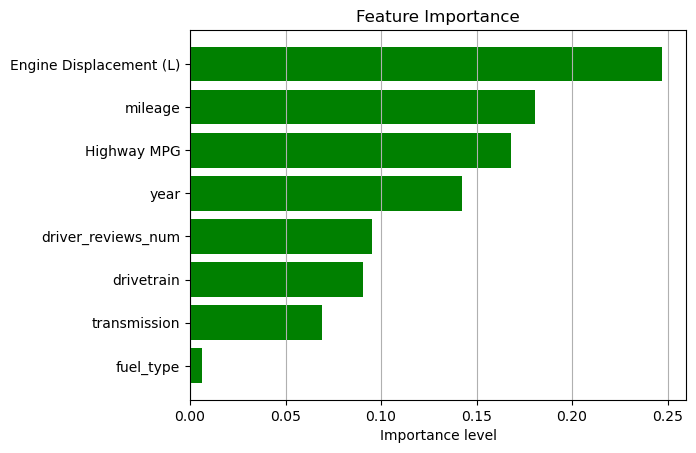

In [116]:

plt.barh(sorted_feature_imp.index,sorted_feature_imp['importance'],color = 'g')
plt.xlabel('Importance level')
plt.title('Feature Importance')
plt.grid(axis='x')  # Add a grid on the x-axis
plt.gca().invert_yaxis()
plt.show()

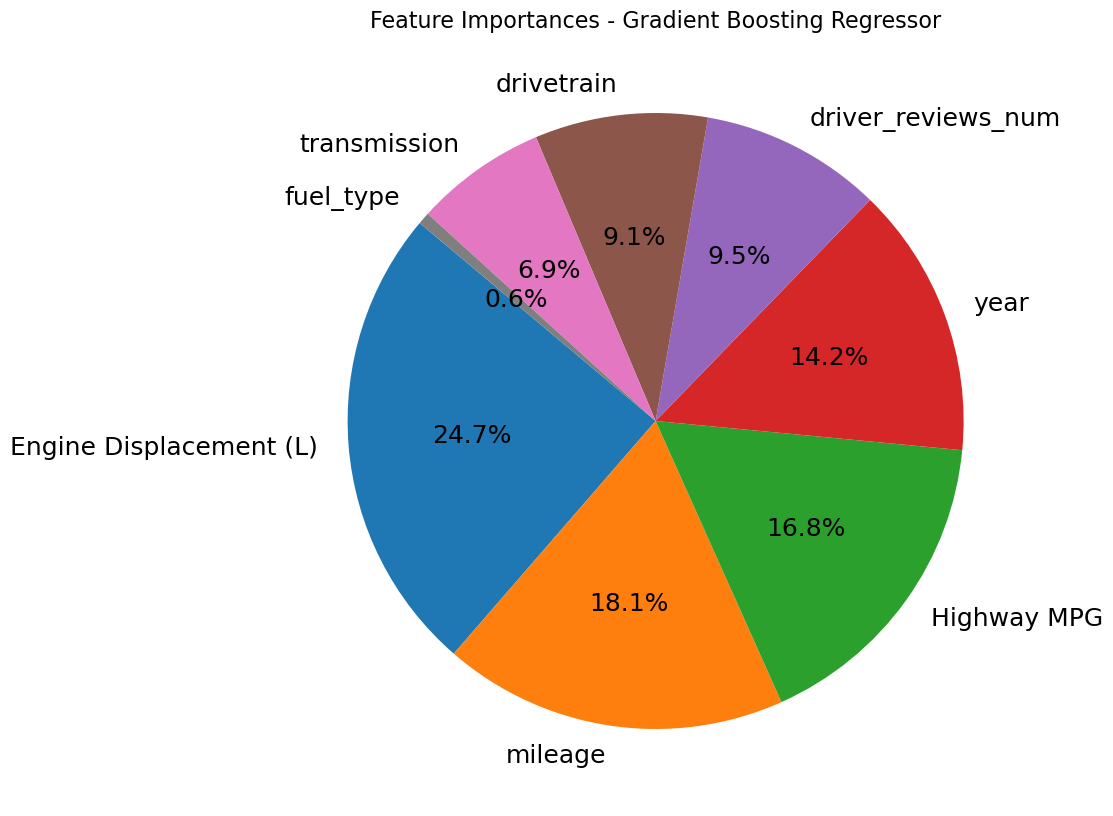

In [117]:
# Plotting
plt.figure(figsize=(10, 10))
plt.pie(sorted_feature_imp['importance'], labels=sorted_feature_imp.index, autopct='%1.1f%%',\
    startangle=140, textprops={'fontsize': 18})
plt.title('Feature Importances - Gradient Boosting Regressor', fontsize=16)
plt.show()


<a id="85"></a>
<font color = 'blue'>
### **8.5. Support Vector Machine (SVM)**
   

We need to standardize the numerical data before using them to fit the SVM model.

In [118]:
best_features

array(['year', 'mileage', 'driver_reviews_num', 'Highway MPG',
       'transmission', 'drivetrain', 'fuel_type',
       'Engine Displacement (L)'], dtype=object)

In [119]:
num_columns= best_features

In [120]:
X_train1= pd.DataFrame(StandardScaler().fit_transform(X_train[num_columns]),columns=num_columns,index=X_train.index)
X_test1= pd.DataFrame(StandardScaler().fit_transform(X_test[num_columns]),columns=num_columns, index=X_test.index)

X_train1 = pd.concat([X_train1, X_train[['drivetrain', 'fuel_type']]], axis=1)
X_test1 = pd.concat([X_test1, X_test[['drivetrain', 'fuel_type']]], axis=1)

In [121]:
svm = SVR()  # You can specify kernel, C, gamma, etc.
param_grid ={'C':[1], 'kernel':['linear']}

* Create Cross-Validation Splitter and Perform Grid Search with Cross-Validation:

In [122]:
cross_validator = skm.KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = skm.GridSearchCV(svm, param_grid, cv=cross_validator, scoring='neg_mean_absolute_error')
grid_search.fit(X_train1, y_train)  # X: feature matrix, y: target variable

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVR(), param_grid={'C': [1], 'kernel': ['linear']},
             scoring='neg_mean_absolute_error')

In [123]:
best_model = grid_search.best_estimator_  # or random_search.best_estimator_
best_params = grid_search.best_params_  # or random_search.best_params_
best_score = grid_search.best_score_  # or random_search.best_score_
print("The best SVR model: ", best_params)

The best SVR model:  {'C': 1, 'kernel': 'linear'}


* Evaluate the Model:


In [124]:
best_score

-5048.355211781309

In [125]:
y_pred=best_model.predict(X_test1)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [126]:
# Append metrics to the DataFrame
metrics_df = metrics_df.append({'Model': type(best_model).__name__, 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)

/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_27368/2026396003.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': type(best_model).__name__, 'MAE': mae, 'MSE': mse, 'R2': r2}, ignore_index=True)


<a id="86"></a>
<font color = 'blue'>
### **8.6. Comparing Models:**

* **MAE** and **MSE**: Lower values are generally better for both MAE and MSE. If comparing two models, the one with the lower MAE or MSE is considered better in terms of accuracy.
* <b>$R^2$</b>: Higher values of $R^2$ are desirable. $R^2$ represents the proportion of the variance explained by the model, so a higher $R^2$ indicates that the model is a better fit to the data. It ranges from 0 to 1, with higher values indicating better explanatory power.

In [127]:
metrics_df

Model          MAE           MSE        R2
0  Degree 3 - Polynomial Reg.  4196.820717  3.039942e+07  0.776487
1       DecisionTreeRegressor  5530.813494  5.393986e+07  0.603405
2       RandomForestRegressor  5485.646948  5.206226e+07  0.617210
3   GradientBoostingRegressor  3251.007182  1.917146e+07  0.859041
4                         SVR  5057.757675  4.676408e+07  0.656165

In [128]:
scaled_metrics_df=metrics_df.copy()

# Custom scaling function
def custom_scaling(value, divisor):
    return value / divisor

# Scale MAE and MSE as per your requirements
scaled_metrics_df['Scaled_MAE'] = scaled_metrics_df['MAE'].apply(lambda x: custom_scaling(x, 10000))
scaled_metrics_df['Scaled_MSE'] = scaled_metrics_df['MSE'].apply(lambda x: custom_scaling(x, 1e8))

# Display the scaled values
print(scaled_metrics_df[['Model', 'Scaled_MAE', 'Scaled_MSE', 'R2']])

                        Model  Scaled_MAE  Scaled_MSE        R2
0  Degree 3 - Polynomial Reg.    0.419682    0.303994  0.776487
1       DecisionTreeRegressor    0.553081    0.539399  0.603405
2       RandomForestRegressor    0.548565    0.520623  0.617210
3   GradientBoostingRegressor    0.325101    0.191715  0.859041
4                         SVR    0.505776    0.467641  0.656165


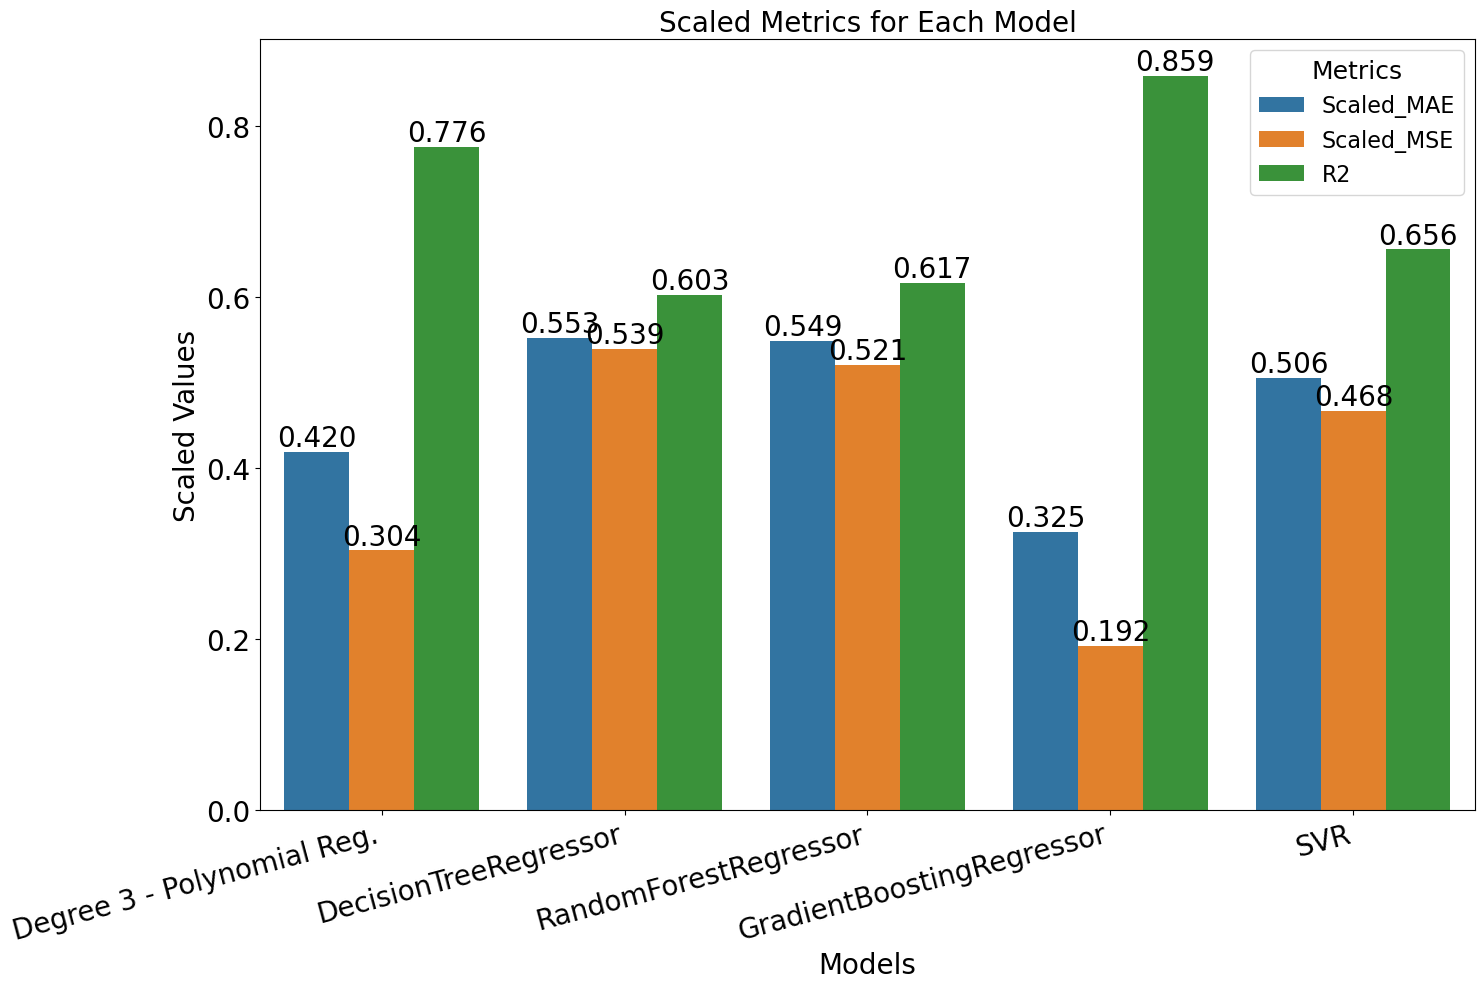

In [129]:

# Melt the dataframe for easier plotting
melted_df = pd.melt(scaled_metrics_df, id_vars=['Model'], value_vars=['Scaled_MAE', 'Scaled_MSE', 'R2'], var_name='Metric')

# Plotting
plt.figure(figsize=(15, 10))
ax = sns.barplot(x='Model', y='value', hue='Metric', data=melted_df)

# Add values on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)

# Add font size
plt.xticks(rotation=15, ha='right', fontsize=20)  # Adjust fontsize as needed
plt.yticks(fontsize=20)  # Adjust fontsize as needed
plt.xlabel('Models', fontsize=20)  # Adjust fontsize as needed
plt.ylabel('Scaled Values', fontsize=20)  # Adjust fontsize as needed
plt.title('Scaled Metrics for Each Model', fontsize=20)  # Adjust fontsize as needed
plt.legend(title='Metrics', title_fontsize='18', fontsize='16')  # Adjust fontsize as needed

# Show the plot
plt.tight_layout()
plt.show()


The lower MAE or MSE is considered better in terms of accuracy and higher values of $R^2$ are desirable

<div class="alert alert-block alert-success">
<b>Evaluation:</b>
Based on the `metrics_df` and `plots`, we can see that `Gradient Boosting Regressor` is the best car price predictor.` Multiple Polynomial Regression` give a reasonable metrics. Therefore, we can use Gradient Boosting Regressor and Multiple Polynomial Regression to understand which features have the most significant impact on the predictions. This can provide insights into what aspects of the data are crucial for predicting car prices.
</div>

In [130]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1016.2504160404205 seconds


In [132]:

print(f"Elapsed time: {elapsed_time/60} minutes")

Elapsed time: 16.937506934007008 minutes
